# Average Metrics Analysis

This .ipynb runs the averageMetrics.py script, and generates multiple analysis plots and charts. 1) P/R per class, per transform, as a table for each model. 2) P/R difference per class, per transform as a table. 3) Multi-Bar Chart per model P/R difference per transform. 4) Per class, Per transform precision and recall averaged over every model (Box plot). 5) Per class, per model performance averaged over all transforms (Box plot). 6) Precision/Recall performance per class, per model, averaged based on the "categories" of transforms (Value/Spatial, sub-categories of each) 7) Perhaps performance per supercategory.

In [179]:
import os
import ast
import subprocess
from multiprocessing import Process, Queue
from multiprocessing import Pool
import glob
import json
import pandas as pd
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [107]:
dataDir='../data/inputs'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,'instances',dataType)
annType = 'bbox'
cocoGt=COCO(annFile)
cats = cocoGt.loadCats(cocoGt.getCatIds())
nms=[cat['name'] for cat in cats]

transformNames = [
 'None',
 'gaussianblur_1',
 'gaussianblur_10',
 'gaussianblur_20',
 'superpixels_0p1',
 'superpixels_0p5',
 'superpixels_0p85',
 'colorspace_25',
 'colorspace_50',
 'averageblur_5_11',
 'medianblur_1',
 'sharpen_0',
 'sharpen_1',
 'sharpen_2',
 'addintensity_-80',
 'addintensity_80',
 'elementrandomintensity_1',
 'multiplyintensity_0p25',
 'multiplyintensity_2',
 'contrastnormalization_0',
 'contrastnormalization_1',
 'contrastnormalization_2',
 'elastic_1',
 'scaled_1p25',
 'scaled_0p75',
 'scaled_0p5',
 'scaled_(1p25, 1p0)',
 'scaled_(0p75, 1p0)',
 'scaled_(1p0, 1p25)',
 'scaled_(1p0, 0p75)',
 'translate_(0p1, 0p1)',
 'translate_(0p1, -0p1)',
 'translate_(-0p1, 0p1)',
 'translate_(-0p1, -0p1)',
 'translate_(0p1, 0)',
 'translate_(-0p1, 0)',
 'translate_(0, 0p1)',
 'translate_(0, -0p1)',
 'rotated_3',
 'rotated_5',
 'rotated_10',
 'rotated_45',
 'rotated_60',
 'rotated_90',
 'flipH',
 'flipV',
 'dropout',
 ]
modelNames = ['e2e_faster_rcnn_R-50-C4_2x',
'e2e_faster_rcnn_R-50-FPN_2x',
'e2e_faster_rcnn_R-101-FPN_2x',
'e2e_faster_rcnn_X-101-64x4d-FPN_2x',
'e2e_mask_rcnn_R-50-C4_2x',
'e2e_mask_rcnn_R-50-FPN_2x',
'e2e_mask_rcnn_R-101-FPN_2x',
'retinanet_R-50-FPN_2x',
'retinanet_R-101-FPN_2x',
'retinanet_X-101-64x4d-FPN_2x']

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


### Read metrics for each model and transform, and parse them into pandas data frames.

In [115]:
metricsColumns = ['model','transform','class','precision','recall','accuracy','TP','FP','FN']
metricsList = []
metrics = pd.DataFrame([], columns=metricsColumns)
regenerate=False


def f(tup):
    print('%s,%s,%s running...'%(tup[1], tup[2], str(tup[0])))
    result = subprocess.check_output(args=["python", "averageMetrics.py", "-c", str(tup[0]), '-r',
                             'basic', tup[1], tup[2]])
    output = result.decode("utf-8")
    # Parse output into a python dict.
    p = re.compile('.+?precision')
    m = p.search(output)
    start = m.start()
    metricStr = output[start:].strip()
    metricObject = ast.literal_eval(metricStr)
    return [tup[1], tup[2], str(tup[0]), metricObject['precision']
                       ,metricObject['recall'],metricObject['accuracy'],metricObject['TP'],
                       metricObject['FP'], metricObject['FN']]

if regenerate:
    # Multiprocess method.
    classLabels = list(map(lambda item: item['id'], cats))
    argumentsList = []
    for model in modelNames:
        for transform in transformNames:
            for classLabel in classLabels:
                argumentsList.append([classLabel, model, transform])


    startTime = time.time()
    p = Pool(6)
    metricsList = p.map(f, argumentsList)
    endTime = time.time()
    print('Total time to run was %s seconds.'%(str(endTime-startTime)))

    # # Single process method.
    # classLabels = list(map(lambda item: item['id'], cats))
    # startTime = time.time()
    # for model in modelNames:
    #     for transform in transformNames:
    #         for i, classLabel in enumerate(classLabels):
    #             print('%s,%s,%s running...'%(model, transform, classLabel))
    #             result = subprocess.check_output(args=["python", "averageMetrics.py", "-c", str(classLabel), '-r',
    #                                      'basic', model, transform])
    #             output = result.decode("utf-8")
    #             # Parse output into a python dict.
    #             p = re.compile('.+?precision')
    #             m = p.search(output)
    #             start = m.start()
    #             metricStr = output[start:].strip()
    #             metricObject = ast.literal_eval(metricStr)
    #             metricsList.append([model, transform, classLabel, metricObject['precision']
    #                                ,metricObject['recall'],metricObject['accuracy'],metricObject['TP'],
    #                                metricObject['FP'], metricObject['FN']])

    # endTime = time.time()
    # print('Total time to run was %s seconds.'%(str(endTime-startTime)))

    # Build the pandas dataframe.
    metrics = pd.DataFrame(metricsList, columns=metricsColumns)
    # Save the pandas dataframe.
    metrics.to_csv('./metrics_dataframe.csv', index=True)

    #Total time to run was 30180.934909582138 seconds.



e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,53 running...
e2e_faster_rcnn_R-50-C4_2x,None,1 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,16 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,86 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),33 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,70 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,87 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,54 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),34 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,17 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,72 running...
e2e_faster_rcnn_R-50-C4_2x,None,2 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,88 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),35 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,55 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,18 running...
e2e_faster_rcnn_R-50-C4_2x,None,3 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,73 run

e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),58 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,43 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,22 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,7 running...
e2e_faster_rcnn_R-50-C4_2x,None,27 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,44 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,82 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),59 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,23 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,8 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,46 running...
e2e_faster_rcnn_R-50-C4_2x,None,28 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,84 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),60 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,24 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,9 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,47 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,8

e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,35 running...
e2e_faster_rcnn_R-50-C4_2x,None,53 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,18 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),88 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,51 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,73 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,36 running...
e2e_faster_rcnn_R-50-C4_2x,None,54 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,19 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,52 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),89 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,74 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,37 running...
e2e_faster_rcnn_R-50-C4_2x,None,55 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,20 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,53 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),90 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_5,75 

e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),23 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,61 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,8 running...
e2e_faster_rcnn_R-50-C4_2x,None,81 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,80 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,47 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),24 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,9 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,62 running...
e2e_faster_rcnn_R-50-C4_2x,None,82 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,81 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,48 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),25 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,63 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,10 running...
e2e_faster_rcnn_R-50-C4_2x,None,84 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p1,82 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,49

e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,17 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,16 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),51 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_1,90 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,75 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,18 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,17 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,37 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),52 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,1 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_1,76 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,18 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,19 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,38 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),53 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,2 running...
e2e_faster_rcnn_R-50-C4

e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,43 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,9 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),78 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,44 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,25 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,44 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,46 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),79 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,61 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,10 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,27 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,46 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,47 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,11 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),80 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,62 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,47 running...
e2

e2e_faster_rcnn_R-50-C4_2x,rotated_10,88 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,72 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),14 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,73 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,52 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,37 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,89 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,73 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,74 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),15 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,53 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,38 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_10,90 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p5,74 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_1,75 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),16 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,54 running...
e2e_faster_rcnn_R-

e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),40 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,7 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,61 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,24 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,80 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,7 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,8 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),41 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,62 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,25 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,81 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,9 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,8 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),42 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,63 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,27 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_2,82 running...
e2e_faster_r

e2e_faster_rcnn_R-50-C4_2x,rotated_45,50 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,89 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,34 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,35 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),65 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,15 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,51 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_2,90 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,35 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),67 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,16 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,52 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,37 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,1 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),70 running...


e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),3 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,78 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,24 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,60 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,42 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,59 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),4 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,79 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,61 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,25 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,43 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,60 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),5 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_45,80 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,62 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,27 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,44 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p

e2e_faster_rcnn_R-50-C4_2x,rotated_60,14 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,89 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,88 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,52 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,70 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),32 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,15 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_10,90 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,89 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,53 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,72 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),33 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,16 running...
e2e_faster_rcnn_R-101-FPN_2x,superpixels_0p85,90 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,1 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,54 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_-80,73 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1

e2e_faster_rcnn_R-50-C4_2x,elastic_1,80 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,24 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,6 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,42 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,24 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),58 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,81 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,7 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,25 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,43 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,25 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),59 running...
e2e_faster_rcnn_R-50-C4_2x,elastic_1,82 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,8 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,27 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,44 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,27 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),60 runnin

e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,52 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,52 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),87 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,17 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,35 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,72 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,53 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),88 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,53 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,18 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,36 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,73 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,54 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,54 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0),89 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,19 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,37 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_60,

e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,80 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,81 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,60 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,44 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),23 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,7 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,81 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,82 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,61 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,46 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),24 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,8 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_25,82 running...
e2e_faster_rcnn_R-50-C4_2x,gaussianblur_20,84 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,62 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,47 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),25 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90

e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,17 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),51 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,89 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,73 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,36 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,18 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,17 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),52 running...
e2e_faster_rcnn_R-50-FPN_2x,addintensity_80,90 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,74 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,37 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,18 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,19 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),53 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_1p25,75 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,1 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,38 running...
e2e_faster_rcnn_R-101-FPN_2x,col

e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),79 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,43 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,44 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,60 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,8 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,24 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),80 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,44 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,61 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,46 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,9 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,25 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(-0p1, 0),81 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,46 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,62 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,47 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,10 running...
e2e_faster_rcnn_R-50-FPN_

e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,70 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,51 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,89 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),15 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,73 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,52 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,72 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_90,90 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),16 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,37 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p1,74 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,53 running...
e2e_faster_rcnn_R-101-FPN_2x,colorspace_50,73 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,1 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),17 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,38 running...
e2e_faster_rcnn_R-50-C

e2e_faster_rcnn_R-50-C4_2x,flipH,24 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,60 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,79 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,8 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,7 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),42 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,25 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,61 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,80 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,9 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),43 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,27 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,8 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,62 running...
e2e_faster_rcnn_R-50-FPN_2x,elementrandomintensity_1,81 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,10 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),44 running...
e2e_faster_rcnn_R-50-C4_2x,fl

e2e_faster_rcnn_R-50-C4_2x,flipH,52 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,34 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,89 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),70 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,16 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,53 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,35 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p75,90 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,37 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),72 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,17 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,36 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,54 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,1 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,38 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, 0p1),73 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyin

e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,59 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,80 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,24 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,43 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),6 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,61 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,60 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,81 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,25 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,44 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),7 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,61 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,62 running...
e2e_faster_rcnn_R-50-C4_2x,flipH,82 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,27 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,46 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),8 running...
e2e_faster_rcnn_R-101-FPN_2x,av

e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),33 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,16 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,52 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,89 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,17 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p5,90 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,72 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),34 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,53 running...
e2e_faster_rcnn_R-101-FPN_2x,averageblur_5_11,90 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,18 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,73 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,1 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),35 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,54 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,1 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_0p25,74 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,

e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,80 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,25 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),59 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,7 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,24 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,44 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,81 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,27 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),60 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,8 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,25 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,46 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_0p5,82 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,28 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),61 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,9 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,47 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,27 run

e2e_faster_rcnn_R-50-C4_2x,flipV,73 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),17 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),88 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,53 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,35 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,52 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,74 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,54 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),18 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,36 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0, -0p1),89 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,53 running...
e2e_faster_rcnn_R-50-C4_2x,flipV,75 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),19 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,55 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,54 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,37 running...
e2e_faster_rcnn_R-50-FPN_2x

e2e_faster_rcnn_R-50-FPN_2x,rotated_3,23 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,9 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,60 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),44 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,81 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,82 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,10 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,24 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,61 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),46 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,82 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,84 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,62 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,11 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,25 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),47 running...
e2e_faster_rcnn_R-101-FPN_2x,medianblur_1,84 running...
e2e_faster_rcnn_R-50-C4_2x,superpixels_0p85,85 r

e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,17 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,52 running...
e2e_faster_rcnn_R-50-FPN_2x,multiplyintensity_2,90 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,18 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),74 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,38 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,18 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,53 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,1 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,19 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),75 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,39 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,19 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,54 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,2 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,20 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),76 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,40 running...
e

e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,25 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,46 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),9 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,81 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,47 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,64 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,27 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,47 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),10 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,82 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,48 running...
e2e_faster_rcnn_R-50-C4_2x,dropout,65 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,28 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,48 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),11 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_3,84 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,49 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormaliza

e2e_faster_rcnn_R-50-FPN_2x,rotated_5,17 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,75 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,75 running...
e2e_faster_rcnn_R-50-FPN_2x,None,3 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,54 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),38 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,76 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,18 running...
e2e_faster_rcnn_R-50-FPN_2x,None,4 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,76 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),39 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,55 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_25,77 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,19 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),40 running...
e2e_faster_rcnn_R-50-FPN_2x,None,5 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_0,77 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,56 running...
e2e_

e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,82 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,11 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),64 running...
e2e_faster_rcnn_R-50-FPN_2x,None,31 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,11 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,47 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,84 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,13 running...
e2e_faster_rcnn_R-50-FPN_2x,None,32 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),65 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,13 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,48 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_0,85 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,14 running...
e2e_faster_rcnn_R-50-FPN_2x,None,33 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),67 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,14 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,49 running...
e

e2e_faster_rcnn_R-50-FPN_2x,None,56 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,40 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,75 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,40 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,19 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),4 running...
e2e_faster_rcnn_R-50-FPN_2x,None,57 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,41 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,76 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,20 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,41 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),5 running...
e2e_faster_rcnn_R-50-FPN_2x,None,58 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,42 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_5,77 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,21 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),6 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,42 running...
e2e_

e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,47 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),32 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,67 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,11 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,67 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,48 running...
e2e_faster_rcnn_R-50-FPN_2x,None,86 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),33 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,70 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,13 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,70 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,49 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),34 running...
e2e_faster_rcnn_R-50-FPN_2x,None,87 running...
e2e_faster_rcnn_R-50-C4_2x,colorspace_50,72 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,14 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_1,72 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormaliza

e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,20 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,39 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,4 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,5 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),58 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,40 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,76 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,21 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,5 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,6 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),59 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,6 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,22 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,41 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_1,77 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,7 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),60 running...
e2e_faster_rcnn_R-101-FPN_2x,sh

e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),86 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,48 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,10 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,33 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,64 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,49 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,33 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),87 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,34 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,11 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,65 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,50 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,34 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),88 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,13 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,35 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_10,67 running...
e2e_faster_r

e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,57 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,38 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,57 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,76 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),21 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,58 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,3 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,39 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,58 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,77 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),22 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,4 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,59 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,40 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,59 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_1,78 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),23 running...
e2e_faster_rcn

e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,85 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,86 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),48 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,63 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,11 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,31 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,87 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,86 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),49 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,64 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,13 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,32 running...
e2e_faster_rcnn_R-50-C4_2x,averageblur_5_11,88 running...
e2e_faster_rcnn_R-101-FPN_2x,sharpen_2,87 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),50 running...
e2e_faster_rcnn_R-50-FPN_2x,contrastnormalization_2,65 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,14 running...
e2e_faste

e2e_faster_rcnn_R-50-FPN_2x,elastic_1,1 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,19 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,55 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,21 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),76 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,20 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,39 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,2 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,56 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,22 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),77 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,40 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,21 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,57 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,3 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,23 running...
e2e_faster_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),78 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,41 run

e2e_faster_rcnn_R-50-FPN_2x,elastic_1,27 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,49 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,64 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,48 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,85 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),11 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,28 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,50 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,65 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,49 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,86 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),13 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,31 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,51 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,50 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_10,67 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_45,87 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,32 runn

e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,76 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,20 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,3 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,55 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),39 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,78 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,77 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,21 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,4 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),40 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,56 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,79 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_-80,78 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,22 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,5 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),41 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,57 running...
e2e_faster_rcnn_R-50-C4_2x,medianblur_1,

e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),64 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,84 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,14 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,32 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,49 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,13 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),65 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,85 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,15 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,33 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,50 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,14 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0p1),67 running...
e2e_faster_rcnn_R-50-FPN_2x,elastic_1,86 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,16 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,34 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,51 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,15 runnin

e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,40 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,57 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,77 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,20 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),4 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,42 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,41 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,78 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,58 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,21 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),5 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,43 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,42 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_60,79 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,59 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,22 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),6 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,44 

e2e_faster_rcnn_R-50-FPN_2x,rotated_90,13 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,48 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,70 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),32 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,87 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,67 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,14 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,49 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,72 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),33 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,88 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,70 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,15 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,50 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_0,73 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),34 running...
e2e_faster_rcnn_R-50-FPN_2x,gaussianblur_20,89 running...
e2e_faster_rcnn_R-101-FPN_2x,addintensity_80,

e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),57 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,6 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,22 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,77 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,41 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),58 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,5 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,7 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,23 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,78 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,42 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,8 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),59 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,6 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,24 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_1p25,79 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,43 running...
e2e_faster_rcnn_R-101-FPN_2x,ele

e2e_faster_rcnn_R-50-C4_2x,sharpen_1,34 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,11 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),86 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,50 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,67 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,33 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,13 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,35 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),87 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,51 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,70 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,34 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,14 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,36 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, -0p1),88 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,52 running...
e2e_faster_rcnn_R-50-FPN_2x,rotated_90,72 running...
e2e_faster_rcnn_R-101-FPN_2

e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,57 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,59 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,39 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,78 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),21 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,5 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,58 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,60 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,40 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,79 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),22 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,6 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,59 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,61 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,41 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p1,80 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),23 running...
e2e_faster_rcnn_R-50-FPN

e2e_faster_rcnn_R-50-FPN_2x,flipH,32 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,88 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,14 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,64 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),49 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,87 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,33 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,89 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,15 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,65 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),50 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandomintensity_1,88 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,34 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_1,90 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,16 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p75,67 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),51 running...
e2e_faster_rcnn_R-101-FPN_2x,elementrandom

e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,41 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,3 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,22 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,24 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,58 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),77 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,42 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,4 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,23 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,25 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,59 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),78 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,43 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,5 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,24 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,27 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,60 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),

e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,50 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,87 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,52 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,70 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),13 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,32 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,53 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,51 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,88 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,72 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),14 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,33 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,54 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,52 running...
e2e_faster_rcnn_R-50-FPN_2x,flipH,89 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p5,73 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),15 running...
e2e_faster_rcnn_R-50-FPN_2x,scale

e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,6 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,78 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,57 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,23 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),40 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,81 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,7 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,79 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,24 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,58 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),41 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,8 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,82 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_0p25,80 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,25 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),42 running...
e2e_faster_rcnn_R-50-C4_2x,sharpen_2,84 running...
e2e_faster_rcnn_R-50-FPN_2x,scale

e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,34 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,16 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,86 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,35 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,51 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,15 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),65 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,17 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,87 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,36 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,52 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,16 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,18 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),67 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_0p5,88 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,17 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,37 running...
e2e_faster_rcnn_R-

e2e_faster_rcnn_R-50-FPN_2x,flipV,78 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,43 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),3 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),20 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,41 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,79 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,60 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),21 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,44 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,42 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),4 running...
e2e_faster_rcnn_R-50-FPN_2x,flipV,80 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,61 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),5 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),22 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,46 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,43 running...
e2e_faster_rcnn

e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,65 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,70 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),48 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,14 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),31 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,67 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,88 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,72 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),49 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,15 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),32 running...
e2e_faster_rcnn_R-101-FPN_2x,multiplyintensity_2,70 running...
e2e_faster_rcnn_R-50-FPN_2x,superpixels_0p85,89 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_-80,73 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),50 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,16 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),33 running...
e2e_fa

e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),55 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,4 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,6 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,22 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,41 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),76 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),56 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,5 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,23 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,7 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),77 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,42 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),57 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,6 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,24 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,8 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),78 running...
e2e

e2e_faster_rcnn_R-50-FPN_2x,dropout,65 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),10 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),84 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,32 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,33 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,50 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,67 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),11 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),85 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,33 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,34 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,51 running...
e2e_faster_rcnn_R-50-FPN_2x,dropout,70 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0p1, 0),86 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),13 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,34 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,35 running...
e2e

e2e_faster_rcnn_R-50-C4_2x,addintensity_80,57 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,56 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,77 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),38 running...
e2e_faster_rcnn_R-101-FPN_2x,None,4 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),19 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,58 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,57 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,78 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),39 running...
e2e_faster_rcnn_R-101-FPN_2x,None,5 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),20 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,59 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,58 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_25,79 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),40 running...
e2e_faster_rcnn_R-101-FPN_2x,None,6 running...
e2e_faster_rcn

e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),62 running...
e2e_faster_rcnn_R-101-FPN_2x,None,31 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,86 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),46 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,85 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,13 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),63 running...
e2e_faster_rcnn_R-101-FPN_2x,None,32 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,87 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),47 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,86 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,14 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),64 running...
e2e_faster_rcnn_R-50-C4_2x,addintensity_80,88 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),48 running...
e2e_faster_rcnn_R-101-FPN_2x,None,33 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_0,87 running...
e2e_fa

e2e_faster_rcnn_R-101-FPN_2x,None,54 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,19 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,39 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,20 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),1 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),73 running...
e2e_faster_rcnn_R-101-FPN_2x,None,55 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,20 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,40 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,21 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),2 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(-0p1, 0),74 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,21 running...
e2e_faster_rcnn_R-101-FPN_2x,None,56 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,22 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,41 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),

e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,47 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,46 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,63 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),25 running...
e2e_faster_rcnn_R-101-FPN_2x,None,81 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),7 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,48 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,47 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,64 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),27 running...
e2e_faster_rcnn_R-101-FPN_2x,None,82 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),8 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,49 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,48 running...
e2e_faster_rcnn_R-50-FPN_2x,colorspace_50,65 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),28 running...
e2e_faster_rcnn_R-101-FPN_2x,None,84

e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,15 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,73 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,1 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),33 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,74 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,16 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),52 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,74 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,2 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),34 running...
e2e_faster_rcnn_R-50-C4_2x,elementrandomintensity_1,75 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),53 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,17 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,3 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_1,75 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),35 running...
e2e_faster_rcnn_R

e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),56 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,7 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,6 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,41 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,25 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),78 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),57 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,8 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,7 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,42 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),79 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,27 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),58 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,9 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,8 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,28 running...
e2e_faster_rcnn_R-

e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,64 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),11 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,33 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,32 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),84 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,52 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,65 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),13 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,34 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,33 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, 0p1),85 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,53 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_1,67 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),14 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,35 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,34 running...
e2e_faster_r

e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),17 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,78 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),37 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,2 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,55 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),18 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,57 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,79 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),38 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,56 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,3 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,58 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),19 running...
e2e_faster_rcnn_R-50-FPN_2x,averageblur_5_11,80 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),39 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,57 running...
e2e_faster_r

e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,25 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),60 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,11 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,84 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),43 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,82 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,27 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,13 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),61 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,85 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),44 running...
e2e_faster_rcnn_R-101-FPN_2x,contrastnormalization_2,84 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,28 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,14 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),62 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_0p25,86 running...
e2e_faster_rcnn_R-50-C4_2x,

e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,18 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,52 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,38 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,17 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),70 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),89 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,53 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,19 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,18 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,39 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),72 running...
e2e_faster_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),90 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,54 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,20 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,19 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,40 running...
e2e_faster_rcnn_R-50-C4_2x,translate_(0, -0p1),73 running...
e2e_faster_

e2e_faster_rcnn_R-50-C4_2x,rotated_3,4 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),23 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,44 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,80 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,63 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,46 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,5 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,46 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),24 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,81 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,64 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,6 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,47 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,47 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),25 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_10,82 running...
e2e_faster_rcnn_R-50-FPN_2x,medianblur_1,65 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,7

e2e_faster_rcnn_R-101-FPN_2x,elastic_1,73 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,2 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),51 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,16 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,74 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,33 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,74 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,3 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),52 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,17 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,75 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,34 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,4 running...
e2e_faster_rcnn_R-101-FPN_2x,elastic_1,75 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,18 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),53 running...
e2e_faster_rcnn_R-50-C4_2x,multiplyintensity_2,76 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,

e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,28 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,43 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),79 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,8 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,58 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,10 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,31 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,44 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,9 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),80 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,59 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,11 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,32 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,46 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),81 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,10 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,60 running...
e2e_faster_rcnn_R-50-C4_2x,contr

e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),14 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,55 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,37 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,36 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,73 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,87 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),15 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,56 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,38 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,37 running...
e2e_faster_rcnn_R-101-FPN_2x,gaussianblur_20,74 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,88 running...
e2e_faster_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),16 running...
e2e_faster_rcnn_R-50-FPN_2x,sharpen_0,57 running...
e2e_faster_rcnn_R-50-C4_2x,contrastnormalization_0,39 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,38 running...
e2e_faster_rcnn_R-50-C4_2x,rotated_3,89 running...
e2e_faster_rcnn_R-101

e2e_faster_rcnn_R-101-FPN_2x,rotated_90,23 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,77 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),49 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,61 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,24 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),37 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),50 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,62 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,25 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),38 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),51 runni

e2e_mask_rcnn_R-50-C4_2x,colorspace_50,23 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,88 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,11 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,51 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),76 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,24 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,13 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,52 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),77 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,25 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_1p25,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,14 running...
e2e_faster_rcnn_R-101-F

e2e_faster_rcnn_R-101-FPN_2x,rotated_90,77 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),88 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,22 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,38 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,78 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),89 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,23 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),10 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,39 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,79 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,52 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),90 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),11 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elemen

e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),22 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,77 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),36 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,13 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,49 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),23 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,78 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),37 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,50 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),24 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_50,79 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),38 running...
e2e_faster_rcnn_R-101-FPN_2x,scal

e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,89 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,76 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,39 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,11 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),49 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elementrandomintensity_1,90 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,40 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,77 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,13 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,1 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,41 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,14 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p75,78 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),62 ru

e2e_faster_rcnn_R-101-FPN_2x,flipH,62 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),88 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,10 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),76 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,24 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,63 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),89 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,11 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),77 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,25 running...
e2e_faster_rcnn_R-101-FPN_2x,flipH,64 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 1p25),90 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,13 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,40 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, 0p1),78 running...
e

e2e_faster_rcnn_R-101-FPN_2x,flipH,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),10 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,62 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),22 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,51 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),11 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,63 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),23 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,52 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),13 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,64 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),24 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,39 running...


e2e_faster_rcnn_R-101-FPN_2x,flipV,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),37 running...
e2e_mask_rcnn_R-50-C4_2x,averageblur_5_11,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,78 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,61 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),49 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),38 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,79 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,62 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),50 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,27 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_0p25,80 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,63 runni

e2e_mask_rcnn_R-50-C4_2x,medianblur_1,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,13 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),62 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,52 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),76 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,25 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_0p5,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),63 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,53 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,27 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p0, 0p75),77 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),64 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,54 running..

e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,39 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),9 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,51 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0, -0p1),90 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,40 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),10 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,52 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,1 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,80 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,41 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),11 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,2 running...
e2e_faster_rcnn_R-101-FPN_2x,flipV,81 running...
e2

e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,63 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,14 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,24 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,79 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,64 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,15 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),38 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,80 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,65 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),52 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,16 running...
e2e_mask_rcnn_R-50-C4_2x,medianblur_1,81 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,multiplyintensity_2,67 runn

e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,2 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),78 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,14 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,51 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,3 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),79 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,15 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,52 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,4 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),80 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,16 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,53 run

e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,27 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,78 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),89 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,65 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),14 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,79 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0p1),90 running...
e2e_faster_rcnn_R-101-FPN_2x,dropout,67 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),15 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,31 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_3,80 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),1 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),16 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,43 

e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,13 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,54 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),23 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),40 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,3 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,65 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,4 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,55 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,15 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_0,67 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),25 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormaliz

e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,27 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),64 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,3 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,81 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,40 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,28 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),65 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,82 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),52 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,31 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),67 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_0,84

e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,52 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),2 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,16 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,64 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),3 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,31 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,17 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_5,65 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,54 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,32 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, -0p1),80 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,18

e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),27 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,79 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,2 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),13 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,42 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,80 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,3 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,43 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),31 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,None,81 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),15 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,56 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1

e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,65 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),38 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,27 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,81 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,67 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),39 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_1,70 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_1,82 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),40 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,16 running...
e2

e2e_mask_rcnn_R-50-C4_2x,sharpen_2,14 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),79 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,3 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,40 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,52 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,15 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),80 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,53 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,16 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),81 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,42 running...
e2e_faster_rcnn_X-101-64x4d-

e2e_mask_rcnn_R-50-C4_2x,sharpen_2,39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,27 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,63 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),14 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,40 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0p1),90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_1,64 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),15 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_10,80 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,31 running...
e2e_faster_rcnn_X-1

e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,11 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,63 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),22 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,52 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,13 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,64 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,53 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),40 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,2 running...
e2e_mask_rcnn_R-50-C4_2x,sharpen_2,65 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,54 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),24 running...
e2e_faster_rcnn_

e2e_mask_rcnn_R-50-C4_2x,sharpen_2,90 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),48 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,24 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,25 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,1 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),49 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,contrastnormalization_2,79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,39 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,27 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),64 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),50 running...
e2e_fast

e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,61 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,11 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,51 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),74 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,62 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, -0p1),75 running...
e2e_faster_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,13 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,52 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,63 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,53 running...
e2e_mask_rcnn_R-50-C4_2x,tra

e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,77 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),22 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,78 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),8 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,51 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_45,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,39 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,52 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_10,79 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2

e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,77 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,11 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),34 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),49 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,62 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,13 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),35 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,63 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_-80,79 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,14 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2

e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,38 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,11 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),76 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,89 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),58 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,39 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,13 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,elastic_1,90 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),77 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,40 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,14 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,1 running...
e2e_mask_rcnn_R-50-C4_2x,translate

e2e_mask_rcnn_R-50-C4_2x,addintensity_80,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,76 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,62 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),86 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),10 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,77 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,63 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),11 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0p1, 0),87 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,39 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_60,78 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,64 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),13 running...
e2e_mask_rcnn_R-50-C4_2x,tr

e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,89 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),19 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,10 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,49 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,gaussianblur_20,90 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),20 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,11 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,1 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),21 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,51 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,64 running...
e2e_faster_rcnn_X-101-64x4d-FPN

e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,36 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,89 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),60 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,76 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,24 running...
e2e_mask_rcnn_R-50-C4_2x,addintensity_80,90 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),61 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_1p25,77 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,38 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,25 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,1 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),62 running...
e2e_mask_rcnn_R-5

e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,22 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,49 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,8 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),87 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),72 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,23 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,9 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),88 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(-0p1, 0),73 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,10 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,61 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),89 running...

e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,75 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),20 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,87 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,49 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,76 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,35 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),21 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,rotated_90,88 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),6 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p1,77 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),22 running...
e2e_fast

e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,57 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,75 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),31 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,9 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,20 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,58 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,76 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,10 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),48 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,21 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,59 running...
e2e_mask_rcnn_R-50-C4_2x,elementrandomintensity_1,77 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),33 running...
e2e_faster_rcnn_X-101-64x4d

e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,35 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,85 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),55 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,36 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),74 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p75,86 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,47 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),56 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,10 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),75 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,48 running...
e2e_faster_rcnn_X-101-6

e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,18 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,59 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),7 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),81 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,19 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,60 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, 0p1),82 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipH,74 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,20 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,61 running...
e2e_mask_rcnn_R-50-C4_2x,tra

e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,86 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),33 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,44 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,87 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),34 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,46 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),16 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p5,88 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,8 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),17 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),35 running...
e2e_faster_rcnn_X-101-64

e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),40 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,70 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),56 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,20 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,87 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,72 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,21 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_0p25,88 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_0p5,73 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),58 running...
e2e_faster_rcnn_X-101-64

e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),82 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),5 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,20 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,56 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),64 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,47 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),84 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),6 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,21 running...
e2e_mask_rcnn_R-50-C4_2x,translate_(0, -0p1),65 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,48 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),85 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),7 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,22 running..

e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),16 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),31 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,82 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,73 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),17 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,84 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,superpixels_0p85,74 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),18 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,3 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,flipV,85 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,48 run

e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,17 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,25 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),43 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),55 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,18 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),44 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,27 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),56 running...
e2e_mask_rcnn_R-50-C4_2x,multiplyintensity_2,74 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,9 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,28 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),46 running.

e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),81 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,52 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,43 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,34 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),70 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),82 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,7 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,44 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,35 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0p1, 0),72 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),84 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,36 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0

e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,70 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,58 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),16 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,79 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,59 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),17 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_3,80 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,60 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,dropout,73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),18 running...
e2e_mask_rcnn_R-50-C4_2x,

e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),31 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,57 running...
e2e_mask_rcnn_R-50-C4_2x,None,5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),42 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,86 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),32 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,58 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),43 running...
e2e_mask_rcnn_R-50-C4_2x,None,6 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_25,87 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),33 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),44 running...
e2e_mask_rcnn_R-50-C4_2x,None,7 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,16 running...
e2e_faster_rcnn_

e2e_mask_rcnn_R-50-C4_2x,rotated_5,40 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,86 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,20 running...
e2e_mask_rcnn_R-50-C4_2x,None,32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),70 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),56 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,41 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,21 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,87 running...
e2e_mask_rcnn_R-50-C4_2x,None,33 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),72 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,22 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_0,88 running...
e2e_mask_rcnn_R-50-C4_2x,None,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),73 running...
e2e_faster_rc

e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,20 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,47 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,65 running...
e2e_mask_rcnn_R-50-C4_2x,None,56 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),85 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),6 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,21 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,48 running...
e2e_mask_rcnn_R-50-C4_2x,None,57 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,67 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),86 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),7 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,22 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,49 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(-0p1, 0),87 running...
e2e_mask_rcnn_R-50-C4_2x,None,58 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_5,70 running...
e2e_faster_rcnn_X-10

e2e_mask_rcnn_R-50-C4_2x,None,82 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),33 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,75 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,48 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),20 running...
e2e_mask_rcnn_R-50-C4_2x,None,84 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,76 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,5 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),21 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,49 running...
e2e_mask_rcnn_R-50-C4_2x,None,85 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,colorspace_50,77 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,6 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),22 running...
e2e_mask_rcnn_R-

e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),46 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,31 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,9 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,75 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,18 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),58 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,10 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_1,76 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,19 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),48 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,11 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,33 running...
e2e_mask_rcnn_R-50-C4_2x,cont

e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,43 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,8 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),85 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,36 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,44 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,9 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,56 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),86 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, 0p1),74 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,37 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,46 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,10 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),87 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0

e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,70 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,59 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),6 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,82 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),19 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,60 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),7 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_10,84 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),20 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_1,73 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,37 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,61 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),8 running...
e2e_mask_rcnn_R-50-C4_2x,rota

e2e_mask_rcnn_R-50-C4_2x,rotated_45,16 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),44 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,59 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,87 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,17 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),46 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,88 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),34 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,18 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),47 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,averageblur_5_11,89 running...
e2e_mask_rcnn_R-50-C4_2x,contrastn

e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,20 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,42 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),57 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,21 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,87 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,32 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),72 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,43 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),58 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,22 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2,88 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),73 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,44 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),59 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,34 running...
e2e_mask_rcnn_R-50-C4_2x,contrastnormalization_2

e2e_mask_rcnn_R-50-C4_2x,elastic_1,21 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),85 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,48 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,70 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,57 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,22 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),86 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,49 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,72 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,58 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,23 running...
e2e_faster_rcnn_R-101-FPN_2x,translate_(0, -0p1),87 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,50 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),8 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_45,73 running...
e2e_mask_rc

e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),34 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,20 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,76 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,86 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,50 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,77 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,21 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,87 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,51 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,medianblur_1,78 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,22 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_10,88 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,52 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60

e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,21 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,78 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,48 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,13 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,22 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,79 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,49 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,14 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,23 running...
e2e_mask_rcnn_R-50-C4_2x,elastic_1,80 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,50 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,36 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,15 run

e2e_mask_rcnn_R-50-C4_2x,rotated_60,59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),89 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,50 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,77 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,40 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,60 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,51 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),90 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,78 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,16 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,41 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,61 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),1 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,52 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,17 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_3,79 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,

e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,65 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,42 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,78 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,13 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,89 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,67 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,43 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,79 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,14 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),27 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_60,90 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_0,70 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,44 running...
e2e_mask_rcnn_R-50-C4_2x,gaussianblur_20,80 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,15 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),28 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_

e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,70 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,24 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,5 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),53 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,15 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,40 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,72 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,25 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,6 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),54 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,41 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,16 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_1p25,73 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,27 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,17 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),55 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,

e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,33 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,7 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,42 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),81 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,65 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,34 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,53 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,43 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),82 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,67 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,35 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,54 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,9 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,44 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),84 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_5,70 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,s

e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,70 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,59 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,81 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,4 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),18 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,36 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,60 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,82 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,5 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,37 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p1,73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,61 running...
e2e_mask_rcnn_R-50-C4_2x,rotated_90,84 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,6 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,38 running...
e2e

e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),44 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,17 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,7 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,89 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,33 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),46 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,61 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,18 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_1,90 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,34 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),47 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,62 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,19 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,1 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),48 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,20

e2e_faster_rcnn_R-101-FPN_2x,rotated_10,58 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),74 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,46 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,24 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p75,90 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,36 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,59 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),75 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,25 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,1 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,37 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,60 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),76 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,48 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,27 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,2 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,61 running...


e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,52 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),10 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,25 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,88 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,75 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,62 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),11 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,27 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,89 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,76 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p5,63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),13 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,28 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_10,90 running...
e2e_mask_rcnn_R-50-C4_2x,flipH,77 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,55 ru

e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,81 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,24 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,10 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,1 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,82 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),39 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,11 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,25 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),40 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,84 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,13 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,27 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,3 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,56 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,sharpen_2,85 running...
e2e_fast

e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),63 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,38 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,27 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,82 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,53 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,18 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),64 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,39 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,84 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,54 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),65 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,31 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,40 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_0p5,85 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,ad

e2e_faster_rcnn_R-101-FPN_2x,rotated_45,80 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),17 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,46 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,81 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,54 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,63 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),2 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),18 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,82 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,47 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,55 running...
e2e_mask_rcnn_R-50-C4_2x,flipV,64 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),3 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,48 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_45,84 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,56 running...
e2e_faster_rcnn_X-10

e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,81 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),44 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),27 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,1 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,17 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,74 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,82 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),46 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,2 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,75 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,18 running...
e2e_mask_rcnn_R-50-C4_2x,superpixels_0p85,84 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),47 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),31 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,3 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_-80,76 running...
e2e_faster

e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,8 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,27 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,43 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),54 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),73 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,18 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,9 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,44 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,28 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),55 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),74 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,19 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,10 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),56 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,46 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,31 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(1p25, 1p0),75 running...
e2e_mask_rcnn_R-50-C

e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,35 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,72 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),82 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,46 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),8 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,54 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,73 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,36 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,47 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(0p1, 0),84 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,74 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,55 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,37 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,48 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_60,75 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),10 running...
e2e_mask_rcnn_R-50-C4_2x,dro

e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),35 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),17 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,7 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,82 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,74 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,addintensity_80,61 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),36 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,8 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),18 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,84 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,75 running...
e2e_mask_rcnn_R-50-FPN_2x,None,5 running...
e2e_mask_rcnn_R-50-C4_2x,scaled_(0p75, 1p0),37 running...
e2e_faster_rcnn_R-101-FPN_2x,rotated_90,9 running...
e2e_faster_rcnn_X-101-64x4d-FPN_2x,translate_(-0p1, 0),19 running...
e2e_mask_rcnn_R-50-C4_2x,dropout,85 running...
e2e_mask_rcnn_R-50-C4_2x,colorspace_25,76 running...
e2e_mask_rcnn_R-50-FPN_2x,None,6 running...
e2e_mas

e2e_mask_rcnn_R-50-FPN_2x,rotated_5,42 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,84 running...
e2e_mask_rcnn_R-50-FPN_2x,None,32 running...
retinanet_R-50-FPN_2x,superpixels_0p1,14 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),56 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,5 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,43 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,85 running...
retinanet_R-50-FPN_2x,superpixels_0p1,15 running...
e2e_mask_rcnn_R-50-FPN_2x,None,33 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),57 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,6 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,86 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,44 running...
retinanet_R-50-FPN_2x,superpixels_0p1,16 running...
e2e_mask_rcnn_R-50-FPN_2x,None,34 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),58 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,7 running...
retinanet_R-50-FPN_2x,superp

e2e_mask_rcnn_R-50-FPN_2x,rotated_5,72 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),86 running...
e2e_mask_rcnn_R-50-FPN_2x,None,58 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,34 running...
retinanet_R-50-FPN_2x,superpixels_0p1,43 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,21 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,73 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),87 running...
e2e_mask_rcnn_R-50-FPN_2x,None,59 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,35 running...
retinanet_R-50-FPN_2x,superpixels_0p1,44 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,22 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,74 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),88 running...
e2e_mask_rcnn_R-50-FPN_2x,None,60 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,36 running...
retinanet_R-50-FPN_2x,superpixels_0p1,46 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,23 running...
e2e_mask_rcnn_R-50-FPN_2x

e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,50 running...
retinanet_R-50-FPN_2x,superpixels_0p1,73 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),22 running...
e2e_mask_rcnn_R-50-FPN_2x,None,88 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,9 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,61 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,51 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),23 running...
retinanet_R-50-FPN_2x,superpixels_0p1,74 running...
e2e_mask_rcnn_R-50-FPN_2x,None,89 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,10 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,62 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,52 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),24 running...
retinanet_R-50-FPN_2x,superpixels_0p1,75 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,11 running...
e2e_mask_rcnn_R-50-FPN_2x,None,90 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,63 running...
e2e_mask_rcnn_R-101-FPN

retinanet_R-50-FPN_2x,superpixels_0p5,9 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,23 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_1,90 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,37 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,79 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),51 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,24 running...
retinanet_R-50-FPN_2x,superpixels_0p5,10 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,1 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,80 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,38 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),52 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,25 running...
retinanet_R-50-FPN_2x,superpixels_0p5,11 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,2 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_1,81 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,39 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),53 runnin

e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,15 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,52 running...
retinanet_R-50-FPN_2x,superpixels_0p5,38 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,62 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),79 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,27 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,16 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,53 running...
retinanet_R-50-FPN_2x,superpixels_0p5,39 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,63 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),80 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,28 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,54 running...
retinanet_R-50-FPN_2x,superpixels_0p5,40 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,17 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_10,64 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0p1),81 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,31 run

e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),15 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,54 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,1 running...
retinanet_R-50-FPN_2x,superpixels_0p5,64 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,81 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,43 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),16 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,55 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,2 running...
retinanet_R-50-FPN_2x,superpixels_0p5,65 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,44 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,82 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),17 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,56 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,3 running...
retinanet_R-50-FPN_2x,superpixels_0p5,67 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,46 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_1,84 run

e2e_mask_rcnn_R-50-FPN_2x,rotated_45,27 running...
retinanet_R-50-FPN_2x,superpixels_0p85,3 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,17 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,72 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),43 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,84 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,28 running...
retinanet_R-50-FPN_2x,superpixels_0p85,4 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,18 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,73 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),44 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,85 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,31 running...
retinanet_R-50-FPN_2x,superpixels_0p85,5 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,19 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_2,74 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),46 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_2,

e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,44 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,19 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,7 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),72 running...
retinanet_R-50-FPN_2x,superpixels_0p85,31 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,55 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,20 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,46 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,8 running...
retinanet_R-50-FPN_2x,superpixels_0p85,32 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,56 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),73 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,47 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,21 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,9 running...
retinanet_R-50-FPN_2x,superpixels_0p85,33 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, -0p1),74 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,57 running...
e2e_mas

e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),7 running...
retinanet_R-50-FPN_2x,superpixels_0p85,57 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,48 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,74 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,85 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,36 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),8 running...
retinanet_R-50-FPN_2x,superpixels_0p85,58 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,49 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,75 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,86 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,37 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),9 running...
retinanet_R-50-FPN_2x,superpixels_0p85,59 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,50 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_10,76 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_45,87 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,38 running...
e2e_mask_rcnn_R-101

e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),36 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,77 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,61 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,21 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,11 running...
retinanet_R-50-FPN_2x,superpixels_0p85,88 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),37 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,78 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,62 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,22 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,13 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,63 running...
retinanet_R-50-FPN_2x,superpixels_0p85,89 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_-80,79 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),38 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,23 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,14 running...
e2e_mask_rcnn_R-50-FPN_2x,elastic_1,64 running...
e2e_mask_rcnn_R-101

e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,14 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,1 running...
retinanet_R-50-FPN_2x,colorspace_25,24 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,15 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),63 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,41 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,50 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,2 running...
retinanet_R-50-FPN_2x,colorspace_25,25 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,16 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,42 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,51 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),64 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,3 running...
retinanet_R-50-FPN_2x,colorspace_25,27 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,43 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0),65 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,17 running...
e2e_mask_rcnn_R-50-

e2e_mask_rcnn_R-50-FPN_2x,rotated_60,78 running...
retinanet_R-50-FPN_2x,colorspace_25,53 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,43 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,70 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),3 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,31 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,79 running...
retinanet_R-50-FPN_2x,colorspace_25,54 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,72 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,44 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,32 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),4 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_60,80 running...
retinanet_R-50-FPN_2x,colorspace_25,55 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,46 running...
e2e_mask_rcnn_R-50-FPN_2x,gaussianblur_20,73 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,33 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),5 running...
e2e_mask_rcnn_R-50-FPN

e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,7 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,16 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),32 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,57 running...
retinanet_R-50-FPN_2x,colorspace_25,82 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,73 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,8 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,17 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),33 running...
retinanet_R-50-FPN_2x,colorspace_25,84 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,58 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,74 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,18 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,9 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),34 running...
retinanet_R-50-FPN_2x,colorspace_25,85 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,59 running...
e2e_mask_rcnn_R-101-FPN_2x,addintensity_80,75 running...
e2e_mask_rcnn_R-50-FPN

e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,86 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,44 running...
retinanet_R-50-FPN_2x,colorspace_50,19 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),58 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,9 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,37 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,87 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,46 running...
retinanet_R-50-FPN_2x,colorspace_50,20 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,10 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),59 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,38 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_1p25,88 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,47 running...
retinanet_R-50-FPN_2x,colorspace_50,21 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,11 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),60 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,39 runn

e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,21 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),87 running...
retinanet_R-50-FPN_2x,colorspace_50,48 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,62 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,38 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,74 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,22 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),88 running...
retinanet_R-50-FPN_2x,colorspace_50,49 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,39 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,63 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,75 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,23 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(-0p1, 0),89 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,40 running...
retinanet_R-50-FPN_2x,colorspace_50,50 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p1,64 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_90,76 run

e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),23 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,9 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,49 running...
retinanet_R-50-FPN_2x,colorspace_50,77 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,64 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,2 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),24 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,10 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,50 running...
retinanet_R-50-FPN_2x,colorspace_50,78 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,65 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),25 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,3 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,51 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,11 running...
retinanet_R-50-FPN_2x,colorspace_50,79 running...
e2e_mask_rcnn_R-101-FPN_2x,elementrandomintensity_1,67 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),27 running...
e2e_mask_

e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),52 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,78 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,38 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,28 running...
retinanet_R-50-FPN_2x,averageblur_5_11,14 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,4 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),53 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,79 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,31 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,39 running...
retinanet_R-50-FPN_2x,averageblur_5_11,15 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,5 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),54 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p75,80 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,32 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,6 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,40 running...
retinanet_R-50-FPN_2x,averageblur_5_11,16 running...
e2e_mask_r

retinanet_R-50-FPN_2x,averageblur_5_11,41 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,63 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,15 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,33 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),82 running...
retinanet_R-50-FPN_2x,averageblur_5_11,42 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,64 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,56 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,16 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, 0p1),84 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,34 running...
retinanet_R-50-FPN_2x,averageblur_5_11,43 running...
e2e_mask_rcnn_R-50-FPN_2x,flipH,65 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,57 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,35 running...
retinanet_R-50-FPN_2x,averageblur_5_11,44 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,17 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,58 running...
e2e_mask_rcnn_R-1

e2e_mask_rcnn_R-50-FPN_2x,flipV,3 running...
retinanet_R-50-FPN_2x,averageblur_5_11,70 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),18 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,86 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,43 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,4 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),19 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,59 running...
retinanet_R-50-FPN_2x,averageblur_5_11,72 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,44 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,87 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,60 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,5 running...
retinanet_R-50-FPN_2x,averageblur_5_11,73 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),20 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,46 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p5,88 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,61 running...
e2e_mask_r

e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,88 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),47 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,21 running...
retinanet_R-50-FPN_2x,medianblur_1,8 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,73 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,33 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),48 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,22 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,89 running...
retinanet_R-50-FPN_2x,medianblur_1,9 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,74 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,34 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),49 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,23 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_0p25,90 running...
retinanet_R-50-FPN_2x,medianblur_1,10 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_0p5,75 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,35 running...
e2e_mask_rcnn_R-10

e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,24 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,50 running...
retinanet_R-50-FPN_2x,medianblur_1,37 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),77 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,59 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),9 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,25 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,51 running...
retinanet_R-50-FPN_2x,medianblur_1,38 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,60 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),78 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),10 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,27 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,52 running...
retinanet_R-50-FPN_2x,medianblur_1,39 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,61 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0, -0p1),79 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),11 running...
e2

e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,79 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,53 running...
retinanet_R-50-FPN_2x,medianblur_1,63 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,89 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,14 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),38 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,80 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,54 running...
retinanet_R-50-FPN_2x,medianblur_1,64 running...
e2e_mask_rcnn_R-50-FPN_2x,flipV,90 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),39 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,15 running...
e2e_mask_rcnn_R-50-FPN_2x,superpixels_0p85,81 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,55 running...
retinanet_R-50-FPN_2x,medianblur_1,65 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,1 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,16 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),40 running...
e2e_mask_rcnn_R-50-FPN_2x,supe

e2e_mask_rcnn_R-50-FPN_2x,dropout,25 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,17 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,84 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),64 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,42 running...
retinanet_R-50-FPN_2x,sharpen_0,4 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,27 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,18 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,85 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),65 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,43 running...
retinanet_R-50-FPN_2x,sharpen_0,5 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,28 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,19 running...
e2e_mask_rcnn_R-101-FPN_2x,multiplyintensity_2,86 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p25, 1p0),67 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,44 running...
retinanet_R-50-FPN_2x,sharpen_0,6 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,31 running..

e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,20 running...
retinanet_R-50-FPN_2x,sharpen_0,33 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,55 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,47 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),5 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,73 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,21 running...
retinanet_R-50-FPN_2x,sharpen_0,34 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,56 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,48 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,74 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),6 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,22 running...
retinanet_R-50-FPN_2x,sharpen_0,35 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,57 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,49 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_3,75 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),7 running...
e2e_mask_rcnn_R-101-FPN_2x,contras

e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),34 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,50 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,9 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,76 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,86 running...
retinanet_R-50-FPN_2x,sharpen_0,60 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,51 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),35 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,10 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,77 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,87 running...
retinanet_R-50-FPN_2x,sharpen_0,61 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,52 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),36 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,11 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_25,78 running...
e2e_mask_rcnn_R-50-FPN_2x,dropout,88 running...
retinanet_R-50-FPN_2x,sharpen_0,62 running...
e2e_mask_rcnn_R-101-FPN_2x,contr

e2e_mask_rcnn_R-101-FPN_2x,None,21 running...
retinanet_R-50-FPN_2x,sharpen_0,90 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,80 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,39 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,14 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),61 running...
e2e_mask_rcnn_R-101-FPN_2x,None,22 running...
retinanet_R-50-FPN_2x,sharpen_1,1 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,81 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,15 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,40 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),62 running...
e2e_mask_rcnn_R-101-FPN_2x,None,23 running...
retinanet_R-50-FPN_2x,sharpen_1,2 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_0,82 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,16 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,41 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(0p75, 1p0),63 running...
e2e_mask_rcnn_R-101-FPN_2x,None,24 runn

e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),1 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,65 running...
retinanet_R-50-FPN_2x,sharpen_1,28 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,18 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,43 running...
e2e_mask_rcnn_R-101-FPN_2x,None,51 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),2 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,67 running...
retinanet_R-50-FPN_2x,sharpen_1,31 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,19 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,44 running...
e2e_mask_rcnn_R-101-FPN_2x,None,52 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),3 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,70 running...
retinanet_R-50-FPN_2x,sharpen_1,32 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,20 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,46 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_5,72 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1

e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,73 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),31 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,6 running...
retinanet_R-50-FPN_2x,sharpen_1,57 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,48 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,74 running...
e2e_mask_rcnn_R-101-FPN_2x,None,80 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),32 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,7 running...
retinanet_R-50-FPN_2x,sharpen_1,58 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,49 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,75 running...
e2e_mask_rcnn_R-101-FPN_2x,None,81 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),33 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,8 running...
retinanet_R-50-FPN_2x,sharpen_1,59 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,50 running...
e2e_mask_rcnn_R-50-FPN_2x,colorspace_50,76 running...
e2e_mask_rcnn_R-101-FPN_2x,No

e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,9 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,16 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,35 running...
retinanet_R-50-FPN_2x,sharpen_1,87 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,77 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),58 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,10 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,17 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,36 running...
retinanet_R-50-FPN_2x,sharpen_1,88 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,78 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),59 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,11 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,18 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,37 running...
retinanet_R-50-FPN_2x,sharpen_1,89 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_1,79 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),60 running

e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),87 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,13 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,38 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,44 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,61 running...
retinanet_R-50-FPN_2x,sharpen_2,23 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),88 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,14 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,39 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,62 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,46 running...
retinanet_R-50-FPN_2x,sharpen_2,24 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 1p25),89 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,40 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,15 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_10,63 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,47 running...
retinanet_R-50-FPN_2x,sharpen_2,25 runnin

e2e_mask_rcnn_R-101-FPN_2x,rotated_10,90 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,73 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,40 running...
retinanet_R-50-FPN_2x,sharpen_2,52 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),23 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,74 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,64 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,1 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,41 running...
retinanet_R-50-FPN_2x,sharpen_2,53 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),24 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,75 running...
e2e_mask_rcnn_R-50-FPN_2x,averageblur_5_11,65 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,42 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,2 running...
retinanet_R-50-FPN_2x,sharpen_2,54 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),25 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_1,76 running..

retinanet_R-50-FPN_2x,sharpen_2,80 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,3 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),51 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,27 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,9 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,67 running...
retinanet_R-50-FPN_2x,sharpen_2,81 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),52 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,4 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,70 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,28 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,10 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),53 running...
retinanet_R-50-FPN_2x,sharpen_2,82 running...
e2e_mask_rcnn_R-101-FPN_2x,contrastnormalization_2,72 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,5 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,31 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,11 running...
retinane

e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,31 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,5 running...
retinanet_R-50-FPN_2x,addintensity_-80,17 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),80 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,38 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,55 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,32 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,6 running...
retinanet_R-50-FPN_2x,addintensity_-80,18 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),81 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,39 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,56 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,33 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,7 running...
retinanet_R-50-FPN_2x,addintensity_-80,19 running...
e2e_mask_rcnn_R-50-FPN_2x,scaled_(1p0, 0p75),82 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,40 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,57 running...
e2e_mask_rcnn_R-50-FPN_2x,me

retinanet_R-50-FPN_2x,addintensity_-80,46 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,35 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),17 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,85 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,64 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,58 running...
retinanet_R-50-FPN_2x,addintensity_-80,47 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,36 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),18 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,86 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,59 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,65 running...
retinanet_R-50-FPN_2x,addintensity_-80,48 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_45,87 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),19 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,60 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,37 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_10,67 running...
retinanet_R-50-FPN_

e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,4 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),46 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,61 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,88 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,21 running...
retinanet_R-50-FPN_2x,addintensity_-80,76 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,5 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,89 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,62 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),47 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,22 running...
retinanet_R-50-FPN_2x,addintensity_-80,77 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,6 running...
e2e_mask_rcnn_R-50-FPN_2x,medianblur_1,90 running...
e2e_mask_rcnn_R-101-FPN_2x,elastic_1,63 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),48 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,23 running...
retinanet_R-50-FPN_2x,addintensity_-80,78 running...
e2e_mask_rcnn_R-101-FP

e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),75 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,50 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,34 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,2 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,25 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),76 running...
retinanet_R-50-FPN_2x,addintensity_80,13 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,51 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,35 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,3 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,27 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),77 running...
retinanet_R-50-FPN_2x,addintensity_80,14 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,52 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,36 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,4 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,28 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0p1),78 running...
retinanet_R-50-FPN_

e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,60 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,31 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,80 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,54 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),13 running...
retinanet_R-50-FPN_2x,addintensity_80,41 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,61 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,32 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,81 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,55 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),14 running...
retinanet_R-50-FPN_2x,addintensity_80,42 running...
e2e_mask_rcnn_R-101-FPN_2x,gaussianblur_20,62 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_60,82 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,33 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),15 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,56 running...
retinanet_R-50-FPN_2x,addintensity_80,43 running...
e2e_mask_rcnn_R-101-FP

e2e_mask_rcnn_R-101-FPN_2x,rotated_90,17 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,84 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),41 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,57 running...
retinanet_R-50-FPN_2x,addintensity_80,70 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,1 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,18 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,85 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),42 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,58 running...
retinanet_R-50-FPN_2x,addintensity_80,72 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,2 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,19 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),43 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_0,86 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,59 running...
retinanet_R-50-FPN_2x,addintensity_80,73 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,3 running...
e2e_mask_rcnn_R-101-FPN_2

e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,87 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,20 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,7 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),70 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,47 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,28 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,88 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),72 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,21 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,8 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,48 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,31 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, -0p1),73 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_1p25,89 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,9 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,22 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,49 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,32 running..

e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,48 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,55 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,75 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,49 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),7 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,36 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,23 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,56 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,76 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,50 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,24 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),8 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,37 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,57 running...
e2e_mask_rcnn_R-101-FPN_2x,rotated_90,77 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,51 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,25 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),9 running...
retinanet

e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,51 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,77 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),35 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,11 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,85 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,52 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,62 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,78 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),36 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,13 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,86 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,63 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,53 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_1,79 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),37 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,14 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p1,87 running...
retinanet_R-50-FPN_2x,elementrandomintensity_1,64 running...
e2e_mask_r

retinanet_R-50-FPN_2x,multiplyintensity_0p25,1 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),61 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,80 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,21 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,15 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,40 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),62 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,2 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,81 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,22 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,16 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),63 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,41 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p75,82 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,3 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,23 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,17 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0p1),64 running...
reti

retinanet_R-50-FPN_2x,multiplyintensity_0p25,28 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,49 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,67 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),2 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,43 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,31 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,18 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,50 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),3 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,70 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,44 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,32 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,19 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,51 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),4 running...
e2e_mask_rcnn_R-101-FPN_2x,flipH,72 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,46 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,20 running...
retinanet_R-50-FPN_

e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,78 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,72 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,6 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,47 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,57 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),31 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,79 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,73 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,7 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,48 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,58 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),32 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p5,80 running...
e2e_mask_rcnn_R-50-FPN_2x,sharpen_2,74 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,8 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,49 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,59 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),33 running...
e2e_mask_rcnn_R-101

e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,15 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,8 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,35 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,76 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),57 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,87 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,16 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,9 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,36 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,77 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),58 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,88 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,17 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,10 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,37 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_0p5,78 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),59 running...
retinanet_R-50-FPN_2x,multiplyintensity_0p25,89 runni

e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),86 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),11 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,22 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,43 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,37 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,61 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),87 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),13 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,23 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,44 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,38 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,62 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, -0p1),88 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),14 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,24 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,46 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,39 running...
e2e_mask_rcnn_R-101-FPN_

e2e_mask_rcnn_R-101-FPN_2x,flipV,89 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),39 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,62 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),22 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,51 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,73 running...
e2e_mask_rcnn_R-101-FPN_2x,flipV,90 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),40 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,63 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),23 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,52 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,74 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),41 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,1 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_-80,64 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),24 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,53 running...
e2e_mask_rcnn_R-101-FPN_2x,superpixels_0p85,75

e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,8 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),50 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,79 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,25 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),64 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,2 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,9 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),51 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,27 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,80 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),65 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,3 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,10 running...
retinanet_R-50-FPN_2x,multiplyintensity_2,81 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),67 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),52 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,28 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p25, 1p0),70 runnin

e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),78 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,15 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,54 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,28 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),4 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,37 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,16 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),79 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,55 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,31 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),5 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,38 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0p1, 0),80 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,17 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,56 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,32 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),6 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,

e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,54 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,62 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),15 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,82 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,43 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,55 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),32 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,63 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),16 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,44 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,56 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,84 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),33 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_25,64 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,46 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),17 running...
e2e_mask_rcnn_R-101-FPN_2x,dropout,85 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_8

e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),57 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),42 running...
retinanet_R-50-FPN_2x,None,18 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,85 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,2 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,73 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),43 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),58 running...
retinanet_R-50-FPN_2x,None,19 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,86 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,74 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,3 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),59 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),44 running...
retinanet_R-50-FPN_2x,None,20 running...
e2e_mask_rcnn_R-50-FPN_2x,addintensity_80,87 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,4 running...
retinanet_R-50-FPN_2x,contrastnormalization_0,75 running...
e2e_mas

e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),86 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,28 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,20 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,8 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),72 running...
retinanet_R-50-FPN_2x,None,47 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),87 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,31 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,21 running...
retinanet_R-50-FPN_2x,None,48 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,9 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0p1, 0),73 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(0p75, 1p0),88 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,32 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,22 running...
retinanet_R-50-FPN_2x,None,49 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,10 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(-0

e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),22 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,55 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,36 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,48 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),7 running...
retinanet_R-50-FPN_2x,None,75 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),23 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,37 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,49 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,56 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),8 running...
retinanet_R-50-FPN_2x,None,76 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),24 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,38 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,57 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,50 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),9 running...
retinanet_R-50-FPN_2x,No

retinanet_R-50-FPN_2x,contrastnormalization_1,61 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),50 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,76 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,84 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),35 running...
retinanet_R-50-FPN_2x,gaussianblur_1,10 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,62 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),51 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,77 running...
e2e_mask_rcnn_R-101-FPN_2x,colorspace_50,85 running...
retinanet_R-50-FPN_2x,gaussianblur_1,11 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),36 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,63 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),52 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),37 running...
e2e_mask_rcnn_R-50-FPN_2x,elementrandomintensity_1,78 running...
retinanet_R-50-FPN_2x,gaussianblur_1,13 running...
e2e_m

e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),59 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,18 running...
retinanet_R-50-FPN_2x,gaussianblur_1,37 running...
retinanet_R-50-FPN_2x,contrastnormalization_1,90 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,11 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),78 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,19 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),60 running...
retinanet_R-50-FPN_2x,gaussianblur_1,38 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,1 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,13 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),61 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 1p25),79 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,20 running...
retinanet_R-50-FPN_2x,gaussianblur_1,39 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,2 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,14 running...
e2e_mask_

e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,38 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,46 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,24 running...
retinanet_R-50-FPN_2x,gaussianblur_1,62 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),88 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),13 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,39 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,47 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,25 running...
retinanet_R-50-FPN_2x,gaussianblur_1,63 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),89 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),14 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,40 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,48 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,27 running...
retinanet_R-50-FPN_2x,gaussianblur_1,64 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, 0p1),90 running...
e2e_mas

retinanet_R-50-FPN_2x,contrastnormalization_2,51 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),22 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),39 running...
retinanet_R-50-FPN_2x,gaussianblur_1,90 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,74 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,63 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,52 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),23 running...
retinanet_R-50-FPN_2x,gaussianblur_10,1 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),40 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,75 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_0p25,64 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,53 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),24 running...
retinanet_R-50-FPN_2x,gaussianblur_10,2 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),41 running...
e2e_mask_rcnn_R-101-FPN_2x,averageblur_5_11,76 running...
e2e_mas

e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,8 running...
retinanet_R-50-FPN_2x,gaussianblur_10,24 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,79 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,1 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),63 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),50 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,9 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,80 running...
retinanet_R-50-FPN_2x,gaussianblur_10,25 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,2 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),64 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),51 running...
retinanet_R-50-FPN_2x,gaussianblur_10,27 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,10 running...
e2e_mask_rcnn_R-101-FPN_2x,scaled_(1p0, 0p75),65 running...
retinanet_R-50-FPN_2x,contrastnormalization_2,81 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,3 running...
retinanet_R-50-FPN_2x,gauss

e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),77 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,36 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,27 running...
retinanet_R-50-FPN_2x,gaussianblur_10,53 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),3 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),78 running...
retinanet_R-50-FPN_2x,elastic_1,16 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,37 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,28 running...
retinanet_R-50-FPN_2x,gaussianblur_10,54 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),4 running...
e2e_mask_rcnn_R-50-FPN_2x,translate_(0, -0p1),79 running...
retinanet_R-50-FPN_2x,elastic_1,17 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,38 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,31 running...
retinanet_R-50-FPN_2x,gaussianblur_10,55 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),5 running...
retinanet_R-50-FPN_2x,elastic_1,18 running...
e

e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,55 running...
retinanet_R-50-FPN_2x,elastic_1,43 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,62 running...
retinanet_R-50-FPN_2x,gaussianblur_10,82 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,15 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,56 running...
retinanet_R-50-FPN_2x,elastic_1,44 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),32 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,63 running...
retinanet_R-50-FPN_2x,gaussianblur_10,84 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),33 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,57 running...
retinanet_R-50-FPN_2x,elastic_1,46 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,16 running...
retinanet_R-50-FPN_2x,gaussianblur_10,85 running...
e2e_mask_rcnn_R-101-FPN_2x,medianblur_1,64 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,58 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),34 running...
retinanet_R-50-FPN

retinanet_R-50-FPN_2x,gaussianblur_20,19 running...
retinanet_R-50-FPN_2x,elastic_1,74 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,43 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),58 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,3 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,86 running...
retinanet_R-50-FPN_2x,gaussianblur_20,20 running...
retinanet_R-50-FPN_2x,elastic_1,75 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,44 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,4 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),59 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,87 running...
retinanet_R-50-FPN_2x,gaussianblur_20,21 running...
retinanet_R-50-FPN_2x,elastic_1,76 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,46 running...
e2e_mask_rcnn_R-50-FPN_2x,multiplyintensity_2,88 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,5 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),60 running...
retinanet_R-50-FPN_2x,gaussianblur_20,22

retinanet_R-50-FPN_2x,scaled_1p25,10 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,22 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),88 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,73 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,32 running...
retinanet_R-50-FPN_2x,gaussianblur_20,50 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),89 running...
retinanet_R-50-FPN_2x,scaled_1p25,11 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,23 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,33 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,74 running...
retinanet_R-50-FPN_2x,gaussianblur_20,51 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, 0p1),90 running...
retinanet_R-50-FPN_2x,scaled_1p25,13 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,24 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_3,75 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,34 running...
retinanet_R-50-FPN_2x,gaussianblur_20,52 running...
e2e_mask_rcnn_R-101

retinanet_R-50-FPN_2x,scaled_1p25,39 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,51 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,9 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,58 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),25 running...
retinanet_R-50-FPN_2x,gaussianblur_20,79 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,52 running...
retinanet_R-50-FPN_2x,scaled_1p25,40 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,10 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,59 running...
retinanet_R-50-FPN_2x,gaussianblur_20,80 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),27 running...
e2e_mask_rcnn_R-50-FPN_2x,contrastnormalization_0,53 running...
retinanet_R-50-FPN_2x,scaled_1p25,41 running...
e2e_mask_rcnn_R-50-FPN_2x,rotated_5,11 running...
e2e_mask_rcnn_R-101-FPN_2x,sharpen_0,60 running...
retinanet_R-50-FPN_2x,gaussianblur_20,81 running...
e2e_mask_rcnn_R-101-FPN_2x,translate_(0p1, -0p1),28 running...
retinanet_R-50-FP

retinanet_R-101-FPN_2x,translate_(-0p1, 0),48 running...
retinanet_R-50-FPN_2x,rotated_90,34 running...
retinanet_R-50-FPN_2x,scaled_1p25,76 running...
retinanet_R-101-FPN_2x,addintensity_80,87 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),60 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,9 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),49 running...
retinanet_R-50-FPN_2x,rotated_90,35 running...
retinanet_R-101-FPN_2x,addintensity_80,88 running...
retinanet_R-50-FPN_2x,scaled_1p25,77 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),61 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,10 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),50 running...
retinanet_R-50-FPN_2x,rotated_90,36 running...
retinanet_R-50-FPN_2x,scaled_1p25,78 running...
retinanet_R-101-FPN_2x,addintensity_80,89 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),62 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,11 running...
retinanet_R-101-FPN_2x,transl

retinanet_R-101-FPN_2x,elementrandomintensity_1,22 running...
retinanet_R-50-FPN_2x,rotated_90,60 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),77 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,38 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),90 running...
retinanet_R-50-FPN_2x,scaled_0p75,13 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,23 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),78 running...
retinanet_R-50-FPN_2x,rotated_90,61 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,39 running...
retinanet_R-50-FPN_2x,scaled_0p75,14 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),1 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,24 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),79 running...
retinanet_R-50-FPN_2x,rotated_90,62 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),2 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,40 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,25 

retinanet_X-101-64x4d-FPN_2x,colorspace_50,63 running...
retinanet_R-50-FPN_2x,scaled_0p75,40 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),14 running...
retinanet_R-50-FPN_2x,rotated_90,90 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),27 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,52 running...
retinanet_R-50-FPN_2x,scaled_0p75,41 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,64 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),15 running...
retinanet_R-50-FPN_2x,flipH,1 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),28 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,53 running...
retinanet_R-50-FPN_2x,scaled_0p75,42 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_50,65 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),16 running...
retinanet_R-50-FPN_2x,flipH,2 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),31 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,54 running...
retinanet_R-50-F

retinanet_R-50-FPN_2x,flipH,25 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),42 running...
retinanet_R-50-FPN_2x,scaled_0p75,70 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),55 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,4 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,81 running...
retinanet_R-50-FPN_2x,flipH,27 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),43 running...
retinanet_R-50-FPN_2x,scaled_0p75,72 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),56 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,5 running...
retinanet_R-101-FPN_2x,elementrandomintensity_1,82 running...
retinanet_R-50-FPN_2x,flipH,28 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),44 running...
retinanet_R-50-FPN_2x,scaled_0p75,73 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),57 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,6 running...
retinanet_R-50-FPN_2x,flipH,31 running...
retinanet_R-101-FPN_2x,elementran

retinanet_R-101-FPN_2x,translate_(0, 0p1),72 running...
retinanet_R-50-FPN_2x,scaled_0p5,7 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,33 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,18 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),85 running...
retinanet_R-50-FPN_2x,flipH,55 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),73 running...
retinanet_R-50-FPN_2x,scaled_0p5,8 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,19 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,34 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),86 running...
retinanet_R-50-FPN_2x,flipH,56 running...
retinanet_R-101-FPN_2x,translate_(0, 0p1),74 running...
retinanet_R-50-FPN_2x,scaled_0p5,9 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,20 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,35 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 1p25),87 running...
retinanet_R-50-FPN_2x,flipH,57 running...
retinanet_R-101-FPN_2x

retinanet_R-101-FPN_2x,multiplyintensity_0p25,47 running...
retinanet_R-50-FPN_2x,scaled_0p5,36 running...
retinanet_R-50-FPN_2x,flipH,85 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),8 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),21 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,60 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,48 running...
retinanet_R-50-FPN_2x,scaled_0p5,37 running...
retinanet_R-50-FPN_2x,flipH,86 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),9 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),22 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,61 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,49 running...
retinanet_R-50-FPN_2x,scaled_0p5,38 running...
retinanet_R-50-FPN_2x,flipH,87 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),10 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),23 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,62 running...
retinanet_R-101-FP

retinanet_R-101-FPN_2x,multiplyintensity_0p25,76 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),50 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),37 running...
retinanet_R-50-FPN_2x,flipV,21 running...
retinanet_R-50-FPN_2x,scaled_0p5,63 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,77 running...
retinanet_X-101-64x4d-FPN_2x,averageblur_5_11,90 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),51 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),38 running...
retinanet_R-50-FPN_2x,flipV,22 running...
retinanet_R-50-FPN_2x,scaled_0p5,64 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,78 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,1 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),52 running...
retinanet_R-50-FPN_2x,flipV,23 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),39 running...
retinanet_R-50-FPN_2x,scaled_0p5,65 running...
retinanet_R-101-FPN_2x,multiplyintensity_0p25,79 running...
retinanet_X-101-64x4d

retinanet_R-101-FPN_2x,translate_(0, -0p1),63 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,14 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),3 running...
retinanet_R-50-FPN_2x,flipV,51 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),80 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,27 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),64 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),4 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,15 running...
retinanet_R-50-FPN_2x,flipV,52 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),81 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,28 running...
retinanet_R-101-FPN_2x,translate_(0, -0p1),65 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,16 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),5 running...
retinanet_R-50-FPN_2x,flipV,53 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p0, 0p75),82 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,31 running...
retinanet_R-101-

retinanet_R-101-FPN_2x,rotated_3,3 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),32 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),17 running...
retinanet_R-50-FPN_2x,flipV,80 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,42 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,55 running...
retinanet_R-101-FPN_2x,rotated_3,4 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),33 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,43 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),18 running...
retinanet_R-50-FPN_2x,flipV,81 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,56 running...
retinanet_R-101-FPN_2x,rotated_3,5 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),34 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),19 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,57 running...
retinanet_R-50-FPN_2x,flipV,82 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,44 running...
retinanet_R-101-FPN_2x,rotated_3,6 runni

retinanet_X-101-64x4d-FPN_2x,medianblur_1,85 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,72 running...
retinanet_R-50-FPN_2x,dropout,17 running...
retinanet_R-101-FPN_2x,rotated_3,34 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),59 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,86 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),47 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,73 running...
retinanet_R-50-FPN_2x,dropout,18 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),60 running...
retinanet_R-101-FPN_2x,rotated_3,35 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),48 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,87 running...
retinanet_R-101-FPN_2x,multiplyintensity_2,74 running...
retinanet_R-50-FPN_2x,dropout,19 running...
retinanet_R-101-FPN_2x,rotated_3,36 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),61 running...
retinanet_X-101-64x4d-FPN_2x,medianblur_1,88 running...
retinanet_X-101-64x4d-FPN_2x,translate_

retinanet_X-101-64x4d-FPN_2x,sharpen_0,22 running...
retinanet_R-50-FPN_2x,dropout,47 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),89 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,9 running...
retinanet_R-101-FPN_2x,rotated_3,60 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),77 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,23 running...
retinanet_R-50-FPN_2x,dropout,48 running...
retinanet_R-101-FPN_2x,rotated_3,61 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,10 running...
retinanet_R-50-FPN_2x,scaled_(1p25, 1p0),90 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),78 running...
retinanet_R-50-FPN_2x,dropout,49 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,11 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),1 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,24 running...
retinanet_R-101-FPN_2x,rotated_3,62 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0p1),79 running...
retinanet_R-50-FPN_2x,dropout,

retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),25 running...
retinanet_R-101-FPN_2x,rotated_3,90 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,51 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),14 running...
retinanet_R-50-FPN_2x,dropout,77 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,39 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),27 running...
retinanet_R-101-FPN_2x,rotated_5,1 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,52 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),15 running...
retinanet_R-50-FPN_2x,dropout,78 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,40 running...
retinanet_R-101-FPN_2x,rotated_5,2 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),28 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),16 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,53 running...
retinanet_R-50-FPN_2x,dropout,79 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,41 running...
retinanet_R-101-FPN_2x,rota

retinanet_R-101-FPN_2x,None,13 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),54 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,80 running...
retinanet_R-101-FPN_2x,rotated_5,31 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,65 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),43 running...
retinanet_R-101-FPN_2x,None,14 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),55 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,81 running...
retinanet_R-101-FPN_2x,rotated_5,32 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,67 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),44 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),56 running...
retinanet_R-101-FPN_2x,None,15 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_0,82 running...
retinanet_R-101-FPN_2x,contrastnormalization_0,70 running...
retinanet_R-101-FPN_2x,rotated_5,33 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),46 running...
retinanet_R-50-FPN_2x,scaled_(0

retinanet_X-101-64x4d-FPN_2x,sharpen_1,17 running...
retinanet_R-101-FPN_2x,None,41 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),73 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,6 running...
retinanet_R-101-FPN_2x,rotated_5,58 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,18 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),85 running...
retinanet_R-101-FPN_2x,None,42 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),74 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,7 running...
retinanet_R-101-FPN_2x,rotated_5,59 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),86 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,19 running...
retinanet_R-101-FPN_2x,None,43 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, -0p1),75 running...
retinanet_R-101-FPN_2x,rotated_5,60 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,8 running...
retinanet_R-50-FPN_2x,scaled_(0p75, 1p0),87 running...
retinanet_X-101-64x4d-FPN_2x,sharp

retinanet_R-101-FPN_2x,None,70 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,47 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),10 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),21 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,35 running...
retinanet_R-101-FPN_2x,rotated_5,89 running...
retinanet_R-101-FPN_2x,None,72 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,48 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),11 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),22 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,36 running...
retinanet_R-101-FPN_2x,rotated_5,90 running...
retinanet_R-101-FPN_2x,None,73 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,49 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),13 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),23 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,37 running...
retinanet_R-101-FPN_2x,rotated_10,1 running...
retinanet_X-101-64x4d-FPN_2x,sh

retinanet_R-101-FPN_2x,rotated_10,24 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,77 running...
retinanet_R-101-FPN_2x,gaussianblur_1,7 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),50 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,61 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),40 running...
retinanet_R-101-FPN_2x,rotated_10,25 running...
retinanet_R-101-FPN_2x,gaussianblur_1,8 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,78 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,62 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),51 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),41 running...
retinanet_R-101-FPN_2x,gaussianblur_1,9 running...
retinanet_R-101-FPN_2x,rotated_10,27 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_1,79 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,63 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),52 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),42 running...
r

retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),65 running...
retinanet_R-101-FPN_2x,contrastnormalization_1,90 running...
retinanet_R-101-FPN_2x,gaussianblur_1,36 running...
retinanet_R-101-FPN_2x,rotated_10,53 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),78 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,15 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),67 running...
retinanet_R-101-FPN_2x,gaussianblur_1,37 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,1 running...
retinanet_R-101-FPN_2x,rotated_10,54 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),79 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0p1),70 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,16 running...
retinanet_R-101-FPN_2x,gaussianblur_1,38 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,2 running...
retinanet_R-101-FPN_2x,rotated_10,55 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 1p25),80 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,17 running...


retinanet_R-101-FPN_2x,gaussianblur_1,61 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),5 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,27 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),15 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,42 running...
retinanet_R-101-FPN_2x,rotated_10,82 running...
retinanet_R-101-FPN_2x,gaussianblur_1,62 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),6 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),16 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,28 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,43 running...
retinanet_R-101-FPN_2x,gaussianblur_1,63 running...
retinanet_R-101-FPN_2x,rotated_10,84 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),7 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,31 running...
retinanet_R-101-FPN_2x,gaussianblur_1,64 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),17 running...
retinanet_R-101-FPN_2x,rotated_10,85 running...

retinanet_X-101-64x4d-FPN_2x,sharpen_2,70 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,54 running...
retinanet_R-101-FPN_2x,gaussianblur_10,1 running...
retinanet_R-101-FPN_2x,rotated_45,19 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),43 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,55 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),34 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,72 running...
retinanet_R-101-FPN_2x,gaussianblur_10,2 running...
retinanet_R-101-FPN_2x,rotated_45,20 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,56 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),44 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),35 running...
retinanet_X-101-64x4d-FPN_2x,sharpen_2,73 running...
retinanet_R-101-FPN_2x,gaussianblur_10,3 running...
retinanet_R-101-FPN_2x,rotated_45,21 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,57 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),46 running...


retinanet_R-101-FPN_2x,gaussianblur_10,27 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,84 running...
retinanet_R-101-FPN_2x,rotated_45,47 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),72 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),59 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,7 running...
retinanet_R-101-FPN_2x,gaussianblur_10,28 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,85 running...
retinanet_R-101-FPN_2x,rotated_45,48 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,8 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),73 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),60 running...
retinanet_R-101-FPN_2x,contrastnormalization_2,86 running...
retinanet_R-101-FPN_2x,gaussianblur_10,31 running...
retinanet_R-101-FPN_2x,rotated_45,49 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,9 running...
retinanet_R-50-FPN_2x,scaled_(1p0, 0p75),74 running...
retinanet_X-101-64x4d-FPN_2x,translate_(

retinanet_R-50-FPN_2x,translate_(0p1, 0p1),7 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,35 running...
retinanet_R-101-FPN_2x,elastic_1,20 running...
retinanet_R-101-FPN_2x,gaussianblur_10,55 running...
retinanet_R-101-FPN_2x,rotated_45,76 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),89 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),8 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,36 running...
retinanet_R-101-FPN_2x,elastic_1,21 running...
retinanet_R-101-FPN_2x,gaussianblur_10,56 running...
retinanet_R-101-FPN_2x,rotated_45,77 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),9 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,37 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, -0p1),90 running...
retinanet_R-101-FPN_2x,gaussianblur_10,57 running...
retinanet_R-101-FPN_2x,elastic_1,22 running...
retinanet_R-101-FPN_2x,rotated_45,78 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,38 running...
retinanet_X-101-

retinanet_R-101-FPN_2x,gaussianblur_10,85 running...
retinanet_R-101-FPN_2x,elastic_1,49 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),24 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),37 running...
retinanet_R-101-FPN_2x,rotated_60,13 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,62 running...
retinanet_R-101-FPN_2x,gaussianblur_10,86 running...
retinanet_R-101-FPN_2x,elastic_1,50 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),25 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),38 running...
retinanet_R-101-FPN_2x,gaussianblur_10,87 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_-80,63 running...
retinanet_R-101-FPN_2x,rotated_60,14 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),27 running...
retinanet_R-101-FPN_2x,elastic_1,51 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),39 running...
retinanet_R-101-FPN_2x,rotated_60,15 running...
retinanet_R-101-FPN_2x,gaussianblur_10,88 running...
retinanet_X-101-64x4d-FPN_

retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),53 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,1 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),63 running...
retinanet_R-101-FPN_2x,gaussianblur_20,22 running...
retinanet_R-101-FPN_2x,elastic_1,79 running...
retinanet_R-101-FPN_2x,rotated_60,41 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),54 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,2 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),64 running...
retinanet_R-101-FPN_2x,gaussianblur_20,23 running...
retinanet_R-101-FPN_2x,elastic_1,80 running...
retinanet_R-101-FPN_2x,rotated_60,42 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),55 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,3 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0p1),65 running...
retinanet_R-101-FPN_2x,gaussianblur_20,24 running...
retinanet_R-101-FPN_2x,elastic_1,81 running...
retinanet_R-101-FPN_2x,rotated_60,43 running...
retinanet_X-101-64x4d-FPN

retinanet_R-101-FPN_2x,gaussianblur_20,51 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),82 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,28 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),3 running...
retinanet_R-101-FPN_2x,scaled_1p25,16 running...
retinanet_R-101-FPN_2x,gaussianblur_20,52 running...
retinanet_R-101-FPN_2x,rotated_60,72 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),84 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,31 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),4 running...
retinanet_R-101-FPN_2x,scaled_1p25,17 running...
retinanet_R-101-FPN_2x,gaussianblur_20,53 running...
retinanet_R-101-FPN_2x,rotated_60,73 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0p1, 0),85 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,32 running...
retinanet_R-101-FPN_2x,scaled_1p25,18 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),5 running...
retinanet_R-101-FPN_2x,rotated_60,74 running...
retinanet_R-101-

retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),19 running...
retinanet_R-101-FPN_2x,gaussianblur_20,81 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,56 running...
retinanet_R-101-FPN_2x,rotated_90,7 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),32 running...
retinanet_R-101-FPN_2x,scaled_1p25,44 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),20 running...
retinanet_R-101-FPN_2x,gaussianblur_20,82 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,57 running...
retinanet_R-101-FPN_2x,rotated_90,8 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),33 running...
retinanet_R-101-FPN_2x,scaled_1p25,46 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),21 running...
retinanet_R-101-FPN_2x,gaussianblur_20,84 running...
retinanet_R-101-FPN_2x,rotated_90,9 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,58 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),34 running...
retinanet_R-101-FPN_2x,scaled_1p25,47 running...
retinanet_X-1

retinanet_X-101-64x4d-FPN_2x,addintensity_80,85 running...
retinanet_R-101-FPN_2x,scaled_1p25,73 running...
retinanet_R-101-FPN_2x,superpixels_0p1,18 running...
retinanet_R-101-FPN_2x,rotated_90,36 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),58 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),49 running...
retinanet_R-101-FPN_2x,scaled_1p25,74 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,86 running...
retinanet_R-101-FPN_2x,superpixels_0p1,19 running...
retinanet_R-101-FPN_2x,rotated_90,37 running...
retinanet_R-101-FPN_2x,scaled_1p25,75 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),59 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),50 running...
retinanet_X-101-64x4d-FPN_2x,addintensity_80,87 running...
retinanet_R-101-FPN_2x,superpixels_0p1,20 running...
retinanet_R-101-FPN_2x,rotated_90,38 running...
retinanet_R-101-FPN_2x,scaled_1p25,76 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),60 running...
retinanet_X-101-64x4d-FP

retinanet_R-101-FPN_2x,superpixels_0p1,46 running...
retinanet_R-101-FPN_2x,scaled_0p75,9 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),87 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),77 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,21 running...
retinanet_R-101-FPN_2x,superpixels_0p1,47 running...
retinanet_R-101-FPN_2x,rotated_90,62 running...
retinanet_R-101-FPN_2x,scaled_0p75,10 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),78 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,22 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),88 running...
retinanet_R-101-FPN_2x,superpixels_0p1,48 running...
retinanet_R-101-FPN_2x,rotated_90,63 running...
retinanet_R-101-FPN_2x,scaled_0p75,11 running...
retinanet_X-101-64x4d-FPN_2x,translate_(-0p1, 0),79 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,23 running...
retinanet_R-50-FPN_2x,translate_(0p1, -0p1),89 running...
retinanet_R-101-FPN_2x,superpixe

retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),22 running...
retinanet_R-101-FPN_2x,scaled_0p75,37 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),13 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,50 running...
retinanet_R-101-FPN_2x,flipH,1 running...
retinanet_R-101-FPN_2x,superpixels_0p1,75 running...
retinanet_R-101-FPN_2x,scaled_0p75,38 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),23 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),14 running...
retinanet_R-101-FPN_2x,flipH,2 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,51 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),24 running...
retinanet_R-101-FPN_2x,superpixels_0p1,76 running...
retinanet_R-101-FPN_2x,scaled_0p75,39 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),15 running...
retinanet_R-101-FPN_2x,flipH,3 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,52 running...
retinanet_R-101-FPN_2x,superpixels_0p1,77 running...
reti

retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),51 running...
retinanet_R-101-FPN_2x,superpixels_0p5,10 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,79 running...
retinanet_R-101-FPN_2x,scaled_0p75,63 running...
retinanet_R-101-FPN_2x,flipH,28 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),41 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),52 running...
retinanet_R-101-FPN_2x,superpixels_0p5,11 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,80 running...
retinanet_R-101-FPN_2x,scaled_0p75,64 running...
retinanet_R-101-FPN_2x,flipH,31 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),42 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),53 running...
retinanet_R-101-FPN_2x,superpixels_0p5,13 running...
retinanet_X-101-64x4d-FPN_2x,elementrandomintensity_1,81 running...
retinanet_R-101-FPN_2x,scaled_0p75,65 running...
retinanet_R-101-FPN_2x,flipH,32 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),54 running...
retin

retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),67 running...
retinanet_R-101-FPN_2x,superpixels_0p5,39 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),80 running...
retinanet_R-101-FPN_2x,flipH,56 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,16 running...
retinanet_R-101-FPN_2x,scaled_0p5,3 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),81 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),70 running...
retinanet_R-101-FPN_2x,superpixels_0p5,40 running...
retinanet_R-101-FPN_2x,flipH,57 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,17 running...
retinanet_R-101-FPN_2x,scaled_0p5,4 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0p1),82 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, 0p1),72 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,18 running...
retinanet_R-101-FPN_2x,superpixels_0p5,41 running...
retinanet_R-101-FPN_2x,flipH,58 running...
retinanet_R-101-FPN_2x,scaled_0p5,5 running...
retinanet_R-5

retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),17 running...
retinanet_R-101-FPN_2x,flipH,85 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,44 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),6 running...
retinanet_R-101-FPN_2x,scaled_0p5,32 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),18 running...
retinanet_R-101-FPN_2x,superpixels_0p5,65 running...
retinanet_R-101-FPN_2x,flipH,86 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,46 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),7 running...
retinanet_R-101-FPN_2x,scaled_0p5,33 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),19 running...
retinanet_R-101-FPN_2x,superpixels_0p5,67 running...
retinanet_R-101-FPN_2x,flipH,87 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,47 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),8 running...
retinanet_R-101-FPN_2x,scaled_0p5,34 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),20 running...
r

retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),46 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,74 running...
retinanet_R-101-FPN_2x,flipV,21 running...
retinanet_R-101-FPN_2x,scaled_0p5,58 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),35 running...
retinanet_R-101-FPN_2x,superpixels_0p85,4 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,75 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),47 running...
retinanet_R-101-FPN_2x,flipV,22 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),36 running...
retinanet_R-101-FPN_2x,scaled_0p5,59 running...
retinanet_R-101-FPN_2x,superpixels_0p85,5 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),48 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_0p25,76 running...
retinanet_R-101-FPN_2x,flipV,23 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),37 running...
retinanet_R-101-FPN_2x,scaled_0p5,60 running...
retinanet_R-101-FPN_2x,superpixels_0p85,6 running...
reti

retinanet_R-101-FPN_2x,superpixels_0p85,32 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),75 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,10 running...
retinanet_R-101-FPN_2x,scaled_0p5,88 running...
retinanet_R-101-FPN_2x,flipV,50 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),61 running...
retinanet_R-101-FPN_2x,superpixels_0p85,33 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,11 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),76 running...
retinanet_R-101-FPN_2x,scaled_0p5,89 running...
retinanet_R-101-FPN_2x,flipV,51 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),62 running...
retinanet_R-101-FPN_2x,superpixels_0p85,34 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,13 running...
retinanet_R-50-FPN_2x,translate_(-0p1, -0p1),77 running...
retinanet_R-101-FPN_2x,scaled_0p5,90 running...
retinanet_R-101-FPN_2x,flipV,52 running...
retinanet_X-101-64x4d-FPN_2x,translate_(0, -0p1),63 running...
retinanet_

retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),23 running...
retinanet_R-101-FPN_2x,flipV,78 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,38 running...
retinanet_R-101-FPN_2x,superpixels_0p85,58 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,1 running...
retinanet_R-101-FPN_2x,flipV,79 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),24 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,39 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),11 running...
retinanet_R-101-FPN_2x,superpixels_0p85,59 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,2 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),25 running...
retinanet_R-101-FPN_2x,flipV,80 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,40 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),13 running...
retinanet_R-101-FPN_2x,superpixels_0p85,60 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,3 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),27 running...
retinanet_R-101-FPN_2x,flipV,8

retinanet_R-101-FPN_2x,superpixels_0p85,88 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,64 running...
retinanet_R-101-FPN_2x,dropout,16 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),53 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),40 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,28 running...
retinanet_R-101-FPN_2x,superpixels_0p85,89 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,65 running...
retinanet_R-101-FPN_2x,dropout,17 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),54 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),41 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,31 running...
retinanet_R-101-FPN_2x,superpixels_0p85,90 running...
retinanet_X-101-64x4d-FPN_2x,multiplyintensity_2,67 running...
retinanet_R-101-FPN_2x,dropout,18 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,32 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),42 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),55 running...
retinanet_R-101-FPN_2x

retinanet_R-101-FPN_2x,dropout,44 running...
retinanet_R-101-FPN_2x,colorspace_25,25 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,56 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,5 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),82 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),67 running...
retinanet_R-101-FPN_2x,dropout,46 running...
retinanet_R-101-FPN_2x,colorspace_25,27 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,57 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,6 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),84 running...
retinanet_R-101-FPN_2x,dropout,47 running...
retinanet_R-50-FPN_2x,translate_(0p1, 0),70 running...
retinanet_R-101-FPN_2x,colorspace_25,28 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,58 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,7 running...
retinanet_R-101-FPN_2x,scaled_(1p25, 1p0),85 running...
retinanet_R-101-FPN_2x,dropout,48 running...
retinanet_R-50-FPN_2x,translate_

retinanet_R-50-FPN_2x,translate_(-0p1, 0),5 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,34 running...
retinanet_R-101-FPN_2x,colorspace_25,55 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,86 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),6 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),19 running...
retinanet_R-101-FPN_2x,dropout,75 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,35 running...
retinanet_R-101-FPN_2x,colorspace_25,56 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,87 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),7 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),20 running...
retinanet_R-101-FPN_2x,dropout,76 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,36 running...
retinanet_R-101-FPN_2x,colorspace_25,57 running...
retinanet_X-101-64x4d-FPN_2x,rotated_3,88 running...
retinanet_R-101-FPN_2x,dropout,77 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),8 running...
retinanet_R-101-FPN_

retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),47 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),34 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,22 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,60 running...
retinanet_X-101-64x4d-FPN_2x,None,11 running...
retinanet_R-101-FPN_2x,colorspace_25,86 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),48 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),35 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,23 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,61 running...
retinanet_X-101-64x4d-FPN_2x,None,13 running...
retinanet_R-101-FPN_2x,colorspace_25,87 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),49 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),36 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,24 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,62 running...
retinanet_X-101-64x4d-FPN_2x,None,14 running...
retinanet_R-101-FPN_2x,colorspace_25,88 running...
retinan

retinanet_R-101-FPN_2x,colorspace_50,21 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),60 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_0,90 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),76 running...
retinanet_X-101-64x4d-FPN_2x,None,39 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,52 running...
retinanet_R-101-FPN_2x,colorspace_50,22 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),61 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,1 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),77 running...
retinanet_X-101-64x4d-FPN_2x,None,40 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),62 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,53 running...
retinanet_R-101-FPN_2x,colorspace_50,23 running...
retinanet_R-101-FPN_2x,scaled_(0p75, 1p0),78 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,2 running...
retinanet_X-101-64x4d-FPN_2x,None,41 running...
retinanet_R-50-FPN_2x,translate_(-0p1, 0),63 running...
retina

retinanet_R-50-FPN_2x,translate_(-0p1, 0),90 running...
retinanet_R-101-FPN_2x,colorspace_50,50 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,27 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),13 running...
retinanet_X-101-64x4d-FPN_2x,None,65 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,80 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),1 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,28 running...
retinanet_R-101-FPN_2x,colorspace_50,51 running...
retinanet_X-101-64x4d-FPN_2x,None,67 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,81 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),14 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),2 running...
retinanet_R-101-FPN_2x,colorspace_50,52 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,31 running...
retinanet_X-101-64x4d-FPN_2x,None,70 running...
retinanet_X-101-64x4d-FPN_2x,rotated_5,82 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),15 running...
retinanet_R

retinanet_R-101-FPN_2x,colorspace_50,78 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,55 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),27 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,17 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,5 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),41 running...
retinanet_R-101-FPN_2x,colorspace_50,79 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,56 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),28 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,18 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,6 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),42 running...
retinanet_R-101-FPN_2x,colorspace_50,80 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,57 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),31 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,19 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),43 running...
retinanet_X-101-64x4d-FPN_2x,gaussian

retinanet_R-101-FPN_2x,averageblur_5_11,14 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,33 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,84 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),54 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,34 running...
retinanet_R-101-FPN_2x,averageblur_5_11,15 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),67 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,44 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,85 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),55 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,35 running...
retinanet_R-101-FPN_2x,averageblur_5_11,16 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_1,86 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 1p25),70 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,46 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),56 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,36 running...
retinanet_R-101-FPN_

retinanet_X-101-64x4d-FPN_2x,rotated_10,72 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),82 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,19 running...
retinanet_R-101-FPN_2x,averageblur_5_11,41 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),5 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,59 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),84 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,73 running...
retinanet_R-101-FPN_2x,averageblur_5_11,42 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,20 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),6 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,60 running...
retinanet_R-50-FPN_2x,translate_(0, 0p1),85 running...
retinanet_X-101-64x4d-FPN_2x,rotated_10,74 running...
retinanet_R-101-FPN_2x,averageblur_5_11,43 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,21 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),7 running...
retinanet_X-101-64x4d-FPN_2x,

retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,46 running...
retinanet_R-101-FPN_2x,averageblur_5_11,67 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,7 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),19 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),33 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,88 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,47 running...
retinanet_R-101-FPN_2x,averageblur_5_11,70 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,8 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),20 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,89 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),34 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,48 running...
retinanet_R-101-FPN_2x,averageblur_5_11,72 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,9 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_1,90 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),21 running...
retinanet_R-101-FPN_2x,s

retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,22 running...
retinanet_R-101-FPN_2x,medianblur_1,5 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,74 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),58 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,35 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),47 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,23 running...
retinanet_R-101-FPN_2x,medianblur_1,6 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,75 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),59 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,36 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),48 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,24 running...
retinanet_R-101-FPN_2x,medianblur_1,7 running...
retinanet_X-101-64x4d-FPN_2x,contrastnormalization_2,76 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),60 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,37 running...
retinanet_R-50-FPN_2x,translate_(

retinanet_X-101-64x4d-FPN_2x,elastic_1,10 running...
retinanet_R-101-FPN_2x,medianblur_1,33 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,60 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),75 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),87 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,51 running...
retinanet_R-101-FPN_2x,medianblur_1,34 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,11 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,61 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),76 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),88 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,52 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,13 running...
retinanet_R-101-FPN_2x,medianblur_1,35 running...
retinanet_R-101-FPN_2x,scaled_(1p0, 0p75),89 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,62 running...
retinanet_R-50-FPN_2x,translate_(0, -0p1),77 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,53 running...
retinanet_X-101-

retinanet_R-101-FPN_2x,translate_(0p1, 0p1),23 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,39 running...
retinanet_X-101-64x4d-FPN_2x,rotated_45,90 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,80 running...
retinanet_R-50-FPN_2x,rotated_3,13 running...
retinanet_R-101-FPN_2x,medianblur_1,60 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,1 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),24 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,40 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,81 running...
retinanet_R-50-FPN_2x,rotated_3,14 running...
retinanet_R-101-FPN_2x,medianblur_1,61 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,41 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,2 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),25 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_10,82 running...
retinanet_R-50-FPN_2x,rotated_3,15 running...
retinanet_R-101-FPN_2x,medianblur_1,62 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,42 

retinanet_R-50-FPN_2x,rotated_3,41 running...
retinanet_R-101-FPN_2x,medianblur_1,90 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,67 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),53 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,28 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,18 running...
retinanet_R-50-FPN_2x,rotated_3,42 running...
retinanet_R-101-FPN_2x,sharpen_0,1 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,70 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),54 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,31 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,19 running...
retinanet_R-50-FPN_2x,rotated_3,43 running...
retinanet_R-101-FPN_2x,sharpen_0,2 running...
retinanet_X-101-64x4d-FPN_2x,elastic_1,72 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,32 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,20 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),55 running...
retinanet_R-50-FPN_2x,rotated_3,44 running...
re

retinanet_R-101-FPN_2x,translate_(0p1, 0p1),82 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,57 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,48 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,7 running...
retinanet_R-101-FPN_2x,sharpen_0,28 running...
retinanet_R-50-FPN_2x,rotated_3,73 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),84 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,58 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,49 running...
retinanet_R-101-FPN_2x,sharpen_0,31 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,8 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),85 running...
retinanet_R-50-FPN_2x,rotated_3,74 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,59 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,50 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,9 running...
retinanet_R-101-FPN_2x,sharpen_0,32 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0p1),86 running...
retinanet_R-50-FPN_2x,rotated_3,75

retinanet_X-101-64x4d-FPN_2x,scaled_1p25,36 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),20 running...
retinanet_R-50-FPN_2x,rotated_5,9 running...
retinanet_R-101-FPN_2x,sharpen_0,57 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,89 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,78 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,37 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),21 running...
retinanet_R-50-FPN_2x,rotated_5,10 running...
retinanet_R-101-FPN_2x,sharpen_0,58 running...
retinanet_X-101-64x4d-FPN_2x,rotated_60,90 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,79 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,38 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),22 running...
retinanet_R-50-FPN_2x,rotated_5,11 running...
retinanet_R-101-FPN_2x,sharpen_0,59 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,1 running...
retinanet_X-101-64x4d-FPN_2x,gaussianblur_20,80 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,3

retinanet_R-101-FPN_2x,sharpen_0,87 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,15 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,63 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),50 running...
retinanet_R-50-FPN_2x,rotated_5,39 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,27 running...
retinanet_R-101-FPN_2x,sharpen_0,88 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,16 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,64 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),51 running...
retinanet_R-50-FPN_2x,rotated_5,40 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,28 running...
retinanet_R-101-FPN_2x,sharpen_0,89 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,17 running...
retinanet_X-101-64x4d-FPN_2x,scaled_1p25,65 running...
retinanet_R-50-FPN_2x,rotated_5,41 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,31 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),52 running...
retinanet_R-101-FPN_2x,sharpen_0,90 runn

retinanet_X-101-64x4d-FPN_2x,rotated_90,55 running...
retinanet_R-50-FPN_2x,rotated_5,65 running...
retinanet_R-101-FPN_2x,sharpen_1,24 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,4 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,44 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),80 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,56 running...
retinanet_R-50-FPN_2x,rotated_5,67 running...
retinanet_R-101-FPN_2x,sharpen_1,25 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,5 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,46 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),81 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,57 running...
retinanet_R-50-FPN_2x,rotated_5,70 running...
retinanet_R-101-FPN_2x,sharpen_1,27 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,6 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,47 running...
retinanet_R-101-FPN_2x,translate_(0p1, -0p1),82 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,58 

retinanet_R-101-FPN_2x,sharpen_1,53 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,86 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),17 running...
retinanet_R-50-FPN_2x,rotated_10,6 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,75 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,34 running...
retinanet_R-101-FPN_2x,sharpen_1,54 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,87 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),18 running...
retinanet_R-50-FPN_2x,rotated_10,7 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,76 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,35 running...
retinanet_R-101-FPN_2x,sharpen_1,55 running...
retinanet_X-101-64x4d-FPN_2x,rotated_90,88 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),19 running...
retinanet_R-50-FPN_2x,rotated_10,8 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p1,77 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,36 running...
retinanet_R-101-FPN_2x,sharpen_1,56 runn

retinanet_R-101-FPN_2x,sharpen_1,84 running...
retinanet_X-101-64x4d-FPN_2x,flipH,23 running...
retinanet_R-50-FPN_2x,rotated_10,36 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,61 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),47 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,13 running...
retinanet_R-101-FPN_2x,sharpen_1,85 running...
retinanet_X-101-64x4d-FPN_2x,flipH,24 running...
retinanet_R-50-FPN_2x,rotated_10,37 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,62 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),48 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,14 running...
retinanet_R-101-FPN_2x,sharpen_1,86 running...
retinanet_X-101-64x4d-FPN_2x,flipH,25 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p75,63 running...
retinanet_R-50-FPN_2x,rotated_10,38 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,15 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),49 running...
retinanet_R-101-FPN_2x,sharpen_1,87 running...
retin

retinanet_R-101-FPN_2x,sharpen_2,21 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,42 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),76 running...
retinanet_X-101-64x4d-FPN_2x,flipH,54 running...
retinanet_R-50-FPN_2x,rotated_10,63 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,2 running...
retinanet_R-101-FPN_2x,sharpen_2,22 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),77 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,43 running...
retinanet_R-50-FPN_2x,rotated_10,64 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,3 running...
retinanet_X-101-64x4d-FPN_2x,flipH,55 running...
retinanet_R-101-FPN_2x,sharpen_2,23 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0p1),78 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,44 running...
retinanet_R-50-FPN_2x,rotated_10,65 running...
retinanet_X-101-64x4d-FPN_2x,flipH,56 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,4 running...
retinanet_R-101-FPN_2x,sharpen_2,24 running...
retinanet_R

retinanet_X-101-64x4d-FPN_2x,flipH,84 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,31 running...
retinanet_R-101-FPN_2x,sharpen_2,51 running...
retinanet_R-50-FPN_2x,rotated_45,4 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),15 running...
retinanet_X-101-64x4d-FPN_2x,flipH,85 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,74 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,32 running...
retinanet_R-101-FPN_2x,sharpen_2,52 running...
retinanet_R-50-FPN_2x,rotated_45,5 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),16 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p5,75 running...
retinanet_X-101-64x4d-FPN_2x,flipH,86 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,33 running...
retinanet_R-101-FPN_2x,sharpen_2,53 running...
retinanet_R-50-FPN_2x,rotated_45,6 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),17 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,34 running...
retinanet_R-101-FPN_2x,sharpen_2,54 running...
retinanet_X-1

retinanet_R-50-FPN_2x,rotated_45,33 running...
retinanet_X-101-64x4d-FPN_2x,flipV,21 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,58 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,11 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),44 running...
retinanet_R-101-FPN_2x,sharpen_2,82 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,59 running...
retinanet_X-101-64x4d-FPN_2x,flipV,22 running...
retinanet_R-50-FPN_2x,rotated_45,34 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,13 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),46 running...
retinanet_R-101-FPN_2x,sharpen_2,84 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,60 running...
retinanet_X-101-64x4d-FPN_2x,flipV,23 running...
retinanet_R-50-FPN_2x,rotated_45,35 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,14 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),47 running...
retinanet_R-101-FPN_2x,sharpen_2,85 running...
retinanet_X-101-64x4d-FPN_2x,flipV,24 running...


retinanet_X-101-64x4d-FPN_2x,flipV,51 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),74 running...
retinanet_R-101-FPN_2x,addintensity_-80,19 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,89 running...
retinanet_R-50-FPN_2x,rotated_45,60 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,41 running...
retinanet_X-101-64x4d-FPN_2x,flipV,52 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),75 running...
retinanet_R-101-FPN_2x,addintensity_-80,20 running...
retinanet_R-50-FPN_2x,rotated_45,61 running...
retinanet_X-101-64x4d-FPN_2x,scaled_0p5,90 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,42 running...
retinanet_X-101-64x4d-FPN_2x,flipV,53 running...
retinanet_R-101-FPN_2x,translate_(-0p1, -0p1),76 running...
retinanet_R-101-FPN_2x,addintensity_-80,21 running...
retinanet_R-50-FPN_2x,rotated_45,62 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),1 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,43 running...
retinanet_X-101-64x4d

retinanet_R-101-FPN_2x,translate_(0p1, 0),10 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,67 running...
retinanet_R-101-FPN_2x,addintensity_-80,48 running...
retinanet_X-101-64x4d-FPN_2x,flipV,81 running...
retinanet_R-50-FPN_2x,rotated_45,90 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),25 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),11 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,70 running...
retinanet_R-101-FPN_2x,addintensity_-80,49 running...
retinanet_X-101-64x4d-FPN_2x,flipV,82 running...
retinanet_R-50-FPN_2x,rotated_60,1 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),27 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),13 running...
retinanet_X-101-64x4d-FPN_2x,flipV,84 running...
retinanet_X-101-64x4d-FPN_2x,superpixels_0p85,72 running...
retinanet_R-101-FPN_2x,addintensity_-80,50 running...
retinanet_R-50-FPN_2x,rotated_60,2 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),28 running...
retinanet_R-101-FP

retinanet_R-101-FPN_2x,addintensity_-80,77 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,6 running...
retinanet_R-50-FPN_2x,rotated_60,25 running...
retinanet_X-101-64x4d-FPN_2x,dropout,19 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),40 running...
retinanet_R-101-FPN_2x,addintensity_-80,78 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,7 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),54 running...
retinanet_R-50-FPN_2x,rotated_60,27 running...
retinanet_X-101-64x4d-FPN_2x,dropout,20 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),41 running...
retinanet_R-101-FPN_2x,addintensity_-80,79 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),55 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,8 running...
retinanet_R-50-FPN_2x,rotated_60,28 running...
retinanet_X-101-64x4d-FPN_2x,dropout,21 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),42 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,9 running...
retinanet_X-101-64x4d-FPN_2x

retinanet_X-101-64x4d-FPN_2x,dropout,48 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),67 running...
retinanet_R-50-FPN_2x,rotated_60,54 running...
retinanet_R-101-FPN_2x,addintensity_80,14 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,36 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),84 running...
retinanet_X-101-64x4d-FPN_2x,dropout,49 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),70 running...
retinanet_R-50-FPN_2x,rotated_60,55 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,37 running...
retinanet_R-101-FPN_2x,addintensity_80,15 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),72 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(1p25, 1p0),85 running...
retinanet_X-101-64x4d-FPN_2x,dropout,50 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,38 running...
retinanet_R-50-FPN_2x,rotated_60,56 running...
retinanet_R-101-FPN_2x,addintensity_80,16 running...
retinanet_R-101-FPN_2x,translate_(0p1, 0),73 running...
retinanet_X-101-64x4d-FPN_2x

retinanet_R-101-FPN_2x,addintensity_80,42 running...
retinanet_R-50-FPN_2x,rotated_60,84 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),6 running...
retinanet_X-101-64x4d-FPN_2x,dropout,78 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,63 running...
retinanet_R-101-FPN_2x,addintensity_80,43 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),20 running...
retinanet_R-50-FPN_2x,rotated_60,85 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),7 running...
retinanet_X-101-64x4d-FPN_2x,dropout,79 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,64 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),21 running...
retinanet_R-101-FPN_2x,addintensity_80,44 running...
retinanet_R-50-FPN_2x,rotated_60,86 running...
retinanet_R-101-FPN_2x,translate_(-0p1, 0),8 running...
retinanet_X-101-64x4d-FPN_2x,dropout,80 running...
retinanet_X-101-64x4d-FPN_2x,colorspace_25,65 running...
retinanet_X-101-64x4d-FPN_2x,scaled_(0p75, 1p0),22 running...
retinanet_R-101-FPN_2x

In [119]:
# Read the pandas dataframe.
metrics = pd.read_csv('./metrics_dataframe.csv')
metrics.head()

Unnamed: 0                       model transform  class  precision  \
0           0  e2e_faster_rcnn_R-50-C4_2x      None      1   0.694159   
1           1  e2e_faster_rcnn_R-50-C4_2x      None      2   0.524687   
2           2  e2e_faster_rcnn_R-50-C4_2x      None      3   0.414337   
3           3  e2e_faster_rcnn_R-50-C4_2x      None      4   0.719739   
4           4  e2e_faster_rcnn_R-50-C4_2x      None      5   0.779220   

     recall  accuracy           TP           FP           FN  
0  0.273512  0.244097  3009.731163  1326.064786  7994.268837  
1  0.156833  0.137323    49.559314    44.895615   266.440686  
2  0.120997  0.103325   233.765708   330.426081  1698.234292  
3  0.247889  0.226068    91.966830    35.811194   279.033170  
4  0.573851  0.493597    82.060714    23.250596    60.939286

# Analysis plots

### Plot of precision and recall over all models, classes, and transforms

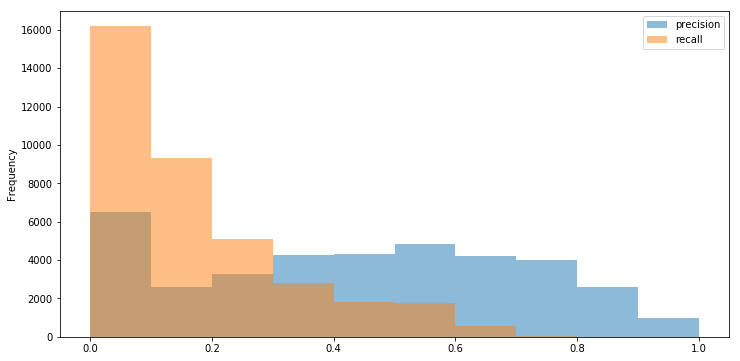

In [138]:
fig_size = [0,0]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

precisionDF = metrics[['precision', 'recall']]
precisionDF.plot.hist(alpha=0.5)

### Plots of precision and recall on the original images, per model.

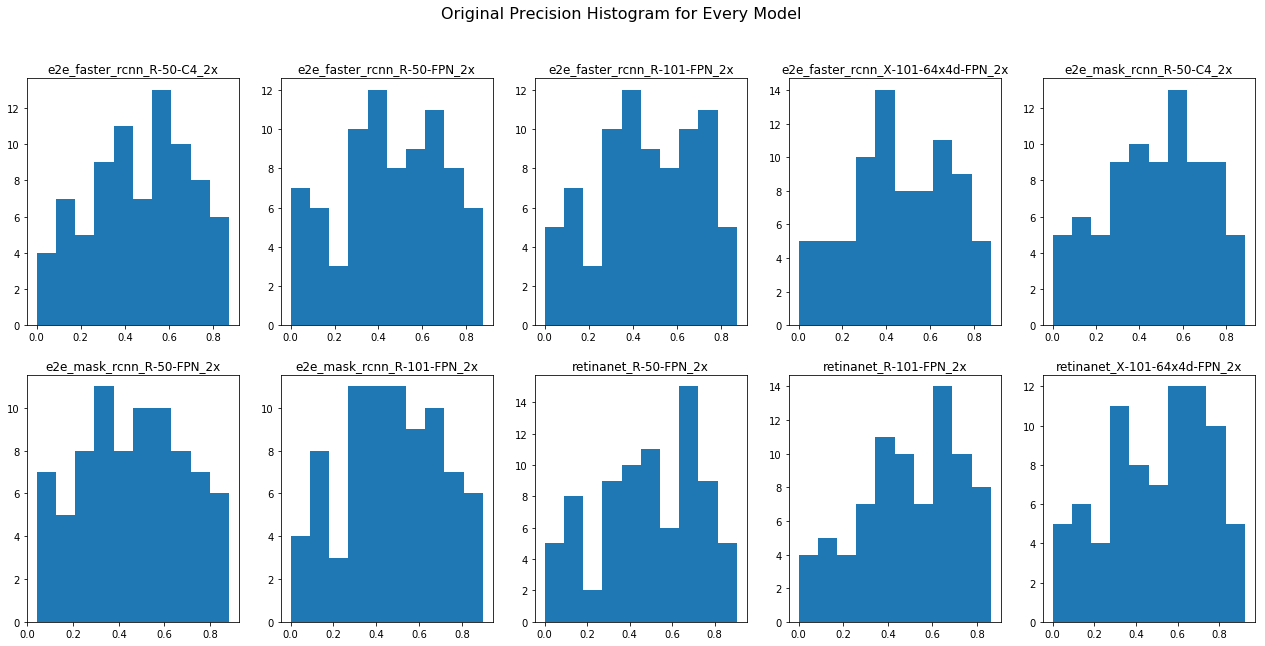

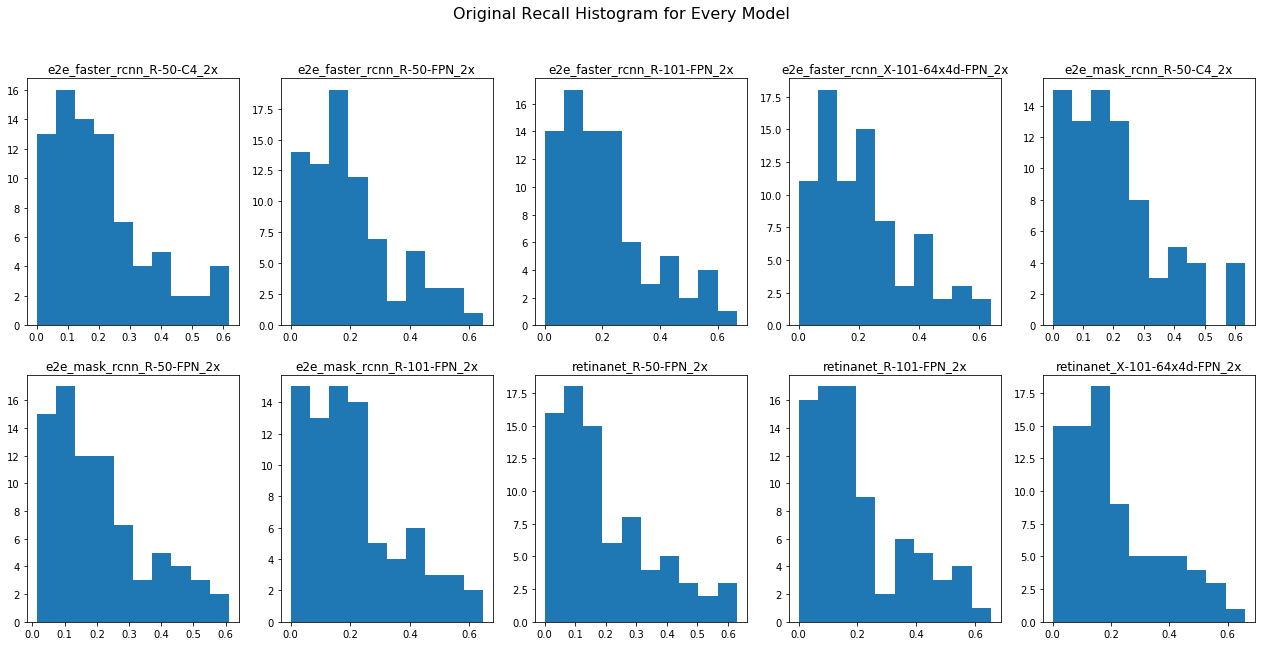

In [162]:
# Set figure size
fig_size = [0,0]
fig_size[0] = 22
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size


f, axarr = plt.subplots(2, 5)
f.suptitle('Original Precision Histogram for Every Model', fontsize=16)
for i, model in enumerate(modelNames):
    axarr[int(i/5), i%5].hist(metrics[(metrics['model'] == model) & (metrics['transform'] == 'None')]['precision'])
    axarr[int(i/5), i%5].set_title(model)


f, axarr = plt.subplots(2, 5)
f.suptitle('Original Recall Histogram for Every Model', fontsize=16)
for i, model in enumerate(modelNames):
    axarr[int(i/5), i%5].hist(metrics[(metrics['model'] == model) & (metrics['transform'] == 'None')]['recall'])
    axarr[int(i/5), i%5].set_title(model)

### Precision tables per class, per model, per transform.

In [190]:
#pd.set_option('display.max_rows', 300)
#display(metrics)
for model in modelNames:
    # Create new table with columns as class (names) and rows as transform.
    table = ListTable()
    table.append(['transform'] + nms)
    modelDF = metrics[metrics['model'] == model]
    
    for transform in transformNames:
        # Get all precision metrics for the transform.
        modelTransformDF = modelDF[modelDF['transform'] == transform]
        precisionSeries = modelTransformDF['precision']
        precisionSeries = list(map(lambda item: '%.3f'%(item), precisionSeries.tolist()))
        table.append([transform] + precisionSeries)
    
    # Display the precision table for the model.
    print('Precision for model %s'%model)
    display(table)

Precision for model e2e_faster_rcnn_R-50-C4_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.694',
  '0.525',
  '0.414',
  '0.720',
  '0.779',
  '0.745',
  '0.852',
  '0.486',
  '0.531',
  '0.272',
  '0.723',
  '0.596',
  '0.689',
  '0.418',
  '0.492',
  '0.655',
  '0.624',
  '0.751',
  '0.649',
  '0.605',
  '0.867',
  '0.816',
  '0.872',
  '0.858',
  '0.140',
  '0.585',
  '0.097',
  '0.040',
  '0.656',
  '0.109',
  '0.306',
  '0.107',
  '0.066',
  '0.579',
  '0.247',
  '0.058',
  '0.315',
  '0.307',
  '0.392',
  '0.266',
  '0.353',
  '0.298',
  '0.422',
  '0.226',
  '0.228',
  '0.390',
  '0.588',
  '0.428',
  '0.540',
  '0.428',
  '0.529',
  '0.305',
  '0.566',
  '0.550',
  '0.626',
  '0.438',
  '0.382',
  '0.628',
  '0.395',
  '0.754',
  '0.466',
  '0.744',
  '0.634',
  '0.642',
  '0.095',
  '0.141',
  '0.464',
  '0.157',
  '0.466',
  '0.607',
  '0.229',
  '0.443',
  '0.795',
  '0.324',
  '0.387',
  '0.312',
  '0.562',
  '0.718',
  '0.000',
  '0.230'],
 ['gaussianblur_1',
  '0.714',
  '0.528',
  '0.451',
  '0.770',
  '0.749',
  '0.719',
  '0.812',
  '0.536',
  '0.546',
  '0.325',
  '0.740',
  '0.706',
  '0.600',
  '0.269',
  '0.545',
  '0.676',
  '0.522',
  '0.704',
  '0.542',
  '0.598',
  '0.849',
  '0.750',
  '0.925',
  '0.875',
  '0.110',
  '0.529',
  '0.189',
  '0.091',
  '0.655',
  '0.068',
  '0.219',
  '0.000',
  '0.067',
  '0.579',
  '0.000',
  '0.000',
  '0.396',
  '0.479',
  '0.478',
  '0.322',
  '0.509',
  '0.253',
  '0.414',
  '0.216',
  '0.000',
  '0.463',
  '0.644',
  '0.313',
  '0.284',
  '0.553',
  '0.549',
  '0.332',
  '0.584',
  '0.545',
  '0.592',
  '0.378',
  '0.382',
  '0.731',
  '0.308',
  '0.826',
  '0.527',
  '0.812',
  '0.642',
  '0.710',
  '0.175',
  '0.114',
  '0.528',
  '0.139',
  '0.449',
  '0.714',
  '0.000',
  '0.360',
  '0.807',
  '0.406',
  '0.484',
  '0.312',
  '0.600',
  '0.817',
  '0.000',
  '0.261'],
 ['gaussianblur_10',
  '0.728',
  '0.000',
  '0.417',
  '0.000',
  '0.000',
  '0.700',
  '0.487',
  '0.000',
  '0.000',
  '0.500',
  '0.667',
  '0.750',
  '0.333',
  '0.000',
  '1.000',
  '0.223',
  '0.208',
  '0.667',
  '0.000',
  '0.500',
  '0.778',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.182',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.103',
  '0.115',
  '0.100',
  '0.000',
  '0.000',
  '0.000',
  '0.417',
  '0.812',
  '0.120',
  '0.000',
  '0.238',
  '1.000',
  '0.500',
  '0.800',
  '0.611',
  '0.214',
  '0.417',
  '0.250',
  '0.000',
  '0.000',
  '1.000',
  '0.462',
  '1.000',
  '0.270',
  '0.714',
  '0.125',
  '0.000',
  '0.000',
  '0.000',
  '0.250',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000'],
 ['gaussianblur_20',
  '0.516',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_faster_rcnn_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.697',
  '0.506',
  '0.405',
  '0.716',
  '0.763',
  '0.768',
  '0.875',
  '0.486',
  '0.531',
  '0.279',
  '0.708',
  '0.625',
  '0.626',
  '0.473',
  '0.497',
  '0.627',
  '0.669',
  '0.713',
  '0.690',
  '0.613',
  '0.858',
  '0.859',
  '0.860',
  '0.856',
  '0.136',
  '0.640',
  '0.071',
  '0.036',
  '0.651',
  '0.095',
  '0.272',
  '0.152',
  '0.061',
  '0.623',
  '0.229',
  '0.055',
  '0.324',
  '0.311',
  '0.372',
  '0.275',
  '0.349',
  '0.269',
  '0.381',
  '0.243',
  '0.166',
  '0.363',
  '0.587',
  '0.415',
  '0.508',
  '0.397',
  '0.517',
  '0.265',
  '0.585',
  '0.546',
  '0.598',
  '0.420',
  '0.386',
  '0.594',
  '0.407',
  '0.825',
  '0.479',
  '0.742',
  '0.604',
  '0.646',
  '0.085',
  '0.138',
  '0.440',
  '0.125',
  '0.420',
  '0.603',
  '0.000',
  '0.421',
  '0.762',
  '0.317',
  '0.352',
  '0.302',
  '0.544',
  '0.708',
  '0.000',
  '0.252'],
 ['gaussianblur_1',
  '0.711',
  '0.567',
  '0.436',
  '0.745',
  '0.793',
  '0.724',
  '0.864',
  '0.606',
  '0.621',
  '0.326',
  '0.762',
  '0.622',
  '0.617',
  '0.372',
  '0.507',
  '0.673',
  '0.537',
  '0.702',
  '0.559',
  '0.630',
  '0.818',
  '0.711',
  '0.933',
  '0.844',
  '0.135',
  '0.572',
  '0.133',
  '0.038',
  '0.690',
  '0.084',
  '0.217',
  '0.100',
  '0.080',
  '0.612',
  '0.000',
  '0.000',
  '0.407',
  '0.563',
  '0.471',
  '0.354',
  '0.513',
  '0.230',
  '0.475',
  '0.281',
  '0.251',
  '0.404',
  '0.650',
  '0.144',
  '0.406',
  '0.413',
  '0.534',
  '0.280',
  '0.648',
  '0.556',
  '0.654',
  '0.317',
  '0.398',
  '0.784',
  '0.381',
  '0.831',
  '0.503',
  '0.785',
  '0.606',
  '0.676',
  '0.091',
  '0.137',
  '0.435',
  '0.132',
  '0.536',
  '0.793',
  '0.000',
  '0.378',
  '0.718',
  '0.316',
  '0.432',
  '0.330',
  '0.286',
  '0.860',
  '0.000',
  '0.176'],
 ['gaussianblur_10',
  '0.686',
  '0.000',
  '0.514',
  '0.000',
  '0.000',
  '0.577',
  '0.400',
  '0.000',
  '0.000',
  '0.200',
  '0.000',
  '0.667',
  '1.000',
  '0.000',
  '0.444',
  '0.500',
  '0.138',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.078',
  '0.000',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.418',
  '0.625',
  '0.055',
  '0.000',
  '0.290',
  '0.000',
  '0.462',
  '1.000',
  '0.397',
  '0.191',
  '0.240',
  '0.102',
  '0.000',
  '0.000',
  '0.000',
  '0.698',
  '1.000',
  '0.354',
  '0.419',
  '0.070',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.636',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_faster_rcnn_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.698',
  '0.507',
  '0.423',
  '0.734',
  '0.770',
  '0.745',
  '0.855',
  '0.491',
  '0.567',
  '0.280',
  '0.752',
  '0.584',
  '0.645',
  '0.472',
  '0.509',
  '0.658',
  '0.659',
  '0.732',
  '0.704',
  '0.637',
  '0.871',
  '0.816',
  '0.842',
  '0.855',
  '0.147',
  '0.644',
  '0.111',
  '0.029',
  '0.665',
  '0.099',
  '0.277',
  '0.164',
  '0.054',
  '0.590',
  '0.294',
  '0.082',
  '0.339',
  '0.305',
  '0.365',
  '0.295',
  '0.359',
  '0.278',
  '0.368',
  '0.228',
  '0.224',
  '0.371',
  '0.611',
  '0.418',
  '0.521',
  '0.400',
  '0.555',
  '0.295',
  '0.474',
  '0.535',
  '0.663',
  '0.476',
  '0.387',
  '0.621',
  '0.409',
  '0.776',
  '0.441',
  '0.704',
  '0.594',
  '0.650',
  '0.092',
  '0.137',
  '0.439',
  '0.143',
  '0.397',
  '0.600',
  '0.000',
  '0.395',
  '0.780',
  '0.332',
  '0.370',
  '0.335',
  '0.581',
  '0.712',
  '0.000',
  '0.210'],
 ['gaussianblur_1',
  '0.712',
  '0.425',
  '0.467',
  '0.787',
  '0.776',
  '0.736',
  '0.830',
  '0.592',
  '0.669',
  '0.254',
  '0.717',
  '0.634',
  '0.497',
  '0.448',
  '0.495',
  '0.683',
  '0.557',
  '0.737',
  '0.595',
  '0.646',
  '0.854',
  '0.789',
  '0.913',
  '0.857',
  '0.154',
  '0.522',
  '0.182',
  '0.034',
  '0.604',
  '0.071',
  '0.234',
  '0.097',
  '0.081',
  '0.639',
  '0.244',
  '0.000',
  '0.374',
  '0.559',
  '0.386',
  '0.372',
  '0.522',
  '0.269',
  '0.349',
  '0.348',
  '0.197',
  '0.392',
  '0.542',
  '0.223',
  '0.379',
  '0.495',
  '0.546',
  '0.266',
  '0.646',
  '0.580',
  '0.797',
  '0.360',
  '0.390',
  '0.696',
  '0.310',
  '0.889',
  '0.467',
  '0.754',
  '0.551',
  '0.679',
  '0.086',
  '0.104',
  '0.519',
  '0.138',
  '0.519',
  '0.808',
  '0.000',
  '0.378',
  '0.692',
  '0.392',
  '0.411',
  '0.342',
  '0.429',
  '0.741',
  '0.000',
  '0.308'],
 ['gaussianblur_10',
  '0.624',
  '0.000',
  '0.398',
  '1.000',
  '1.000',
  '0.692',
  '0.545',
  '1.000',
  '0.000',
  '0.333',
  '0.500',
  '0.667',
  '0.500',
  '0.000',
  '0.207',
  '0.065',
  '0.000',
  '0.793',
  '0.000',
  '0.600',
  '1.000',
  '1.000',
  '0.000',
  '1.000',
  '0.000',
  '0.308',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.140',
  '0.077',
  '0.043',
  '0.000',
  '1.000',
  '0.000',
  '0.333',
  '0.365',
  '0.200',
  '1.000',
  '0.387',
  '0.250',
  '0.840',
  '0.333',
  '0.464',
  '0.390',
  '0.210',
  '0.267',
  '0.000',
  '1.000',
  '1.000',
  '0.275',
  '1.000',
  '0.370',
  '0.690',
  '0.105',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.200',
  '0.000',
  '0.000',
  '1.000',
  '0.400',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.468',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_faster_rcnn_X-101-64x4d-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.689',
  '0.536',
  '0.408',
  '0.735',
  '0.768',
  '0.777',
  '0.876',
  '0.484',
  '0.527',
  '0.281',
  '0.704',
  '0.572',
  '0.623',
  '0.404',
  '0.477',
  '0.682',
  '0.656',
  '0.727',
  '0.748',
  '0.669',
  '0.866',
  '0.847',
  '0.848',
  '0.834',
  '0.131',
  '0.654',
  '0.103',
  '0.043',
  '0.661',
  '0.102',
  '0.259',
  '0.182',
  '0.067',
  '0.619',
  '0.300',
  '0.060',
  '0.359',
  '0.304',
  '0.327',
  '0.286',
  '0.402',
  '0.312',
  '0.359',
  '0.238',
  '0.214',
  '0.358',
  '0.582',
  '0.411',
  '0.458',
  '0.447',
  '0.487',
  '0.276',
  '0.472',
  '0.531',
  '0.589',
  '0.421',
  '0.371',
  '0.568',
  '0.420',
  '0.713',
  '0.419',
  '0.726',
  '0.604',
  '0.628',
  '0.083',
  '0.153',
  '0.443',
  '0.136',
  '0.409',
  '0.614',
  '0.322',
  '0.420',
  '0.722',
  '0.297',
  '0.364',
  '0.303',
  '0.486',
  '0.688',
  '0.000',
  '0.180'],
 ['gaussianblur_1',
  '0.716',
  '0.511',
  '0.464',
  '0.753',
  '0.744',
  '0.812',
  '0.892',
  '0.518',
  '0.578',
  '0.268',
  '0.726',
  '0.665',
  '0.584',
  '0.382',
  '0.449',
  '0.692',
  '0.513',
  '0.730',
  '0.574',
  '0.577',
  '0.804',
  '0.836',
  '0.919',
  '0.859',
  '0.198',
  '0.536',
  '0.155',
  '0.047',
  '0.600',
  '0.079',
  '0.198',
  '0.000',
  '0.097',
  '0.588',
  '0.176',
  '0.000',
  '0.367',
  '0.482',
  '0.398',
  '0.324',
  '0.553',
  '0.275',
  '0.353',
  '0.347',
  '0.217',
  '0.386',
  '0.562',
  '0.258',
  '0.309',
  '0.520',
  '0.530',
  '0.293',
  '0.647',
  '0.520',
  '0.647',
  '0.387',
  '0.375',
  '0.622',
  '0.325',
  '0.790',
  '0.389',
  '0.790',
  '0.567',
  '0.696',
  '0.112',
  '0.165',
  '0.481',
  '0.142',
  '0.465',
  '0.721',
  '0.000',
  '0.380',
  '0.674',
  '0.375',
  '0.411',
  '0.306',
  '0.258',
  '0.752',
  '0.000',
  '0.251'],
 ['gaussianblur_10',
  '0.555',
  '0.000',
  '0.399',
  '1.000',
  '0.000',
  '0.647',
  '0.667',
  '0.333',
  '0.000',
  '0.556',
  '0.000',
  '1.000',
  '0.667',
  '0.235',
  '0.156',
  '0.229',
  '0.250',
  '1.000',
  '0.000',
  '1.000',
  '0.696',
  '1.000',
  '0.000',
  '1.000',
  '0.000',
  '0.297',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.051',
  '0.000',
  '0.026',
  '0.000',
  '0.000',
  '0.000',
  '0.301',
  '0.615',
  '0.068',
  '0.000',
  '0.302',
  '0.000',
  '0.404',
  '1.000',
  '0.551',
  '0.247',
  '0.104',
  '0.093',
  '0.000',
  '0.353',
  '1.000',
  '0.479',
  '1.000',
  '0.223',
  '0.441',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.431',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_mask_rcnn_R-50-C4_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.698',
  '0.533',
  '0.402',
  '0.721',
  '0.786',
  '0.731',
  '0.886',
  '0.481',
  '0.520',
  '0.270',
  '0.721',
  '0.606',
  '0.649',
  '0.417',
  '0.487',
  '0.664',
  '0.618',
  '0.716',
  '0.670',
  '0.601',
  '0.850',
  '0.817',
  '0.861',
  '0.838',
  '0.151',
  '0.612',
  '0.123',
  '0.018',
  '0.676',
  '0.085',
  '0.272',
  '0.119',
  '0.055',
  '0.558',
  '0.236',
  '0.050',
  '0.316',
  '0.292',
  '0.380',
  '0.271',
  '0.394',
  '0.312',
  '0.431',
  '0.235',
  '0.253',
  '0.389',
  '0.601',
  '0.484',
  '0.535',
  '0.467',
  '0.559',
  '0.330',
  '0.535',
  '0.547',
  '0.609',
  '0.489',
  '0.375',
  '0.626',
  '0.412',
  '0.719',
  '0.461',
  '0.762',
  '0.648',
  '0.660',
  '0.103',
  '0.153',
  '0.476',
  '0.171',
  '0.513',
  '0.598',
  '0.212',
  '0.431',
  '0.768',
  '0.302',
  '0.378',
  '0.317',
  '0.683',
  '0.737',
  '0.000',
  '0.217'],
 ['gaussianblur_1',
  '0.721',
  '0.539',
  '0.442',
  '0.730',
  '0.771',
  '0.795',
  '0.863',
  '0.533',
  '0.528',
  '0.327',
  '0.719',
  '0.697',
  '0.713',
  '0.401',
  '0.467',
  '0.666',
  '0.509',
  '0.678',
  '0.586',
  '0.571',
  '0.855',
  '0.893',
  '0.912',
  '0.879',
  '0.154',
  '0.571',
  '0.172',
  '0.003',
  '0.575',
  '0.088',
  '0.191',
  '0.000',
  '0.063',
  '0.606',
  '0.146',
  '0.000',
  '0.308',
  '0.519',
  '0.395',
  '0.349',
  '0.566',
  '0.239',
  '0.520',
  '0.243',
  '0.000',
  '0.417',
  '0.650',
  '0.302',
  '0.375',
  '0.690',
  '0.561',
  '0.396',
  '0.576',
  '0.540',
  '0.637',
  '0.454',
  '0.373',
  '0.736',
  '0.361',
  '0.787',
  '0.510',
  '0.807',
  '0.611',
  '0.682',
  '0.128',
  '0.116',
  '0.510',
  '0.153',
  '0.537',
  '0.732',
  '0.000',
  '0.417',
  '0.728',
  '0.358',
  '0.480',
  '0.294',
  '0.333',
  '0.795',
  '0.000',
  '0.226'],
 ['gaussianblur_10',
  '0.723',
  '0.000',
  '0.314',
  '1.000',
  '1.000',
  '1.000',
  '0.600',
  '0.000',
  '0.000',
  '0.500',
  '0.833',
  '0.750',
  '0.333',
  '0.000',
  '0.500',
  '0.092',
  '0.160',
  '1.000',
  '0.000',
  '0.000',
  '0.846',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.049',
  '0.000',
  '0.143',
  '0.000',
  '0.000',
  '0.000',
  '0.416',
  '0.923',
  '0.067',
  '0.000',
  '0.316',
  '0.000',
  '0.889',
  '1.000',
  '0.543',
  '0.750',
  '0.182',
  '0.000',
  '0.000',
  '0.000',
  '0.667',
  '0.333',
  '1.000',
  '0.199',
  '1.000',
  '0.080',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.091',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.560',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.039',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_mask_rcnn_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.697',
  '0.512',
  '0.414',
  '0.734',
  '0.783',
  '0.755',
  '0.876',
  '0.523',
  '0.529',
  '0.273',
  '0.754',
  '0.597',
  '0.630',
  '0.433',
  '0.485',
  '0.641',
  '0.613',
  '0.721',
  '0.689',
  '0.637',
  '0.883',
  '0.808',
  '0.867',
  '0.841',
  '0.135',
  '0.620',
  '0.107',
  '0.040',
  '0.665',
  '0.097',
  '0.256',
  '0.156',
  '0.060',
  '0.608',
  '0.262',
  '0.060',
  '0.331',
  '0.311',
  '0.375',
  '0.272',
  '0.346',
  '0.272',
  '0.358',
  '0.225',
  '0.201',
  '0.371',
  '0.567',
  '0.414',
  '0.507',
  '0.403',
  '0.522',
  '0.288',
  '0.538',
  '0.521',
  '0.586',
  '0.449',
  '0.375',
  '0.610',
  '0.407',
  '0.749',
  '0.468',
  '0.676',
  '0.611',
  '0.596',
  '0.102',
  '0.140',
  '0.468',
  '0.106',
  '0.433',
  '0.592',
  '0.309',
  '0.434',
  '0.799',
  '0.316',
  '0.365',
  '0.303',
  '0.666',
  '0.768',
  '0.261',
  '0.197'],
 ['gaussianblur_1',
  '0.717',
  '0.527',
  '0.458',
  '0.811',
  '0.802',
  '0.714',
  '0.843',
  '0.522',
  '0.622',
  '0.309',
  '0.682',
  '0.613',
  '0.611',
  '0.365',
  '0.449',
  '0.660',
  '0.511',
  '0.749',
  '0.538',
  '0.587',
  '0.836',
  '0.729',
  '0.929',
  '0.868',
  '0.162',
  '0.468',
  '0.119',
  '0.000',
  '0.715',
  '0.080',
  '0.190',
  '0.084',
  '0.083',
  '0.519',
  '0.105',
  '0.000',
  '0.451',
  '0.614',
  '0.479',
  '0.323',
  '0.543',
  '0.235',
  '0.348',
  '0.389',
  '0.133',
  '0.410',
  '0.523',
  '0.186',
  '0.384',
  '0.459',
  '0.555',
  '0.257',
  '0.851',
  '0.522',
  '0.709',
  '0.375',
  '0.354',
  '0.714',
  '0.315',
  '0.845',
  '0.518',
  '0.805',
  '0.540',
  '0.720',
  '0.128',
  '0.135',
  '0.534',
  '0.138',
  '0.363',
  '0.736',
  '0.000',
  '0.403',
  '0.831',
  '0.382',
  '0.421',
  '0.279',
  '0.429',
  '0.810',
  '0.000',
  '0.250'],
 ['gaussianblur_10',
  '0.649',
  '0.000',
  '0.486',
  '0.000',
  '0.000',
  '0.500',
  '0.667',
  '0.500',
  '0.000',
  '0.333',
  '0.600',
  '0.545',
  '0.333',
  '1.000',
  '0.667',
  '0.068',
  '0.231',
  '0.833',
  '0.000',
  '0.111',
  '0.600',
  '1.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.102',
  '0.000',
  '0.089',
  '0.000',
  '0.000',
  '0.000',
  '0.438',
  '0.557',
  '0.107',
  '0.000',
  '0.297',
  '0.000',
  '0.698',
  '0.000',
  '0.545',
  '0.243',
  '0.186',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.617',
  '0.556',
  '0.324',
  '0.684',
  '0.130',
  '0.000',
  '0.000',
  '0.000',
  '0.333',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.543',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model e2e_mask_rcnn_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.695',
  '0.517',
  '0.421',
  '0.724',
  '0.776',
  '0.765',
  '0.898',
  '0.491',
  '0.544',
  '0.275',
  '0.749',
  '0.561',
  '0.709',
  '0.480',
  '0.500',
  '0.682',
  '0.610',
  '0.722',
  '0.702',
  '0.651',
  '0.854',
  '0.854',
  '0.861',
  '0.853',
  '0.123',
  '0.635',
  '0.105',
  '0.017',
  '0.648',
  '0.115',
  '0.274',
  '0.114',
  '0.067',
  '0.584',
  '0.247',
  '0.083',
  '0.323',
  '0.313',
  '0.358',
  '0.280',
  '0.386',
  '0.280',
  '0.372',
  '0.253',
  '0.148',
  '0.401',
  '0.590',
  '0.436',
  '0.543',
  '0.428',
  '0.519',
  '0.309',
  '0.527',
  '0.529',
  '0.613',
  '0.449',
  '0.381',
  '0.603',
  '0.441',
  '0.765',
  '0.459',
  '0.701',
  '0.608',
  '0.686',
  '0.102',
  '0.119',
  '0.451',
  '0.121',
  '0.473',
  '0.666',
  '0.321',
  '0.435',
  '0.824',
  '0.304',
  '0.366',
  '0.312',
  '0.532',
  '0.722',
  '0.000',
  '0.207'],
 ['gaussianblur_1',
  '0.725',
  '0.517',
  '0.459',
  '0.729',
  '0.755',
  '0.778',
  '0.845',
  '0.523',
  '0.633',
  '0.211',
  '0.645',
  '0.742',
  '0.592',
  '0.461',
  '0.499',
  '0.679',
  '0.624',
  '0.725',
  '0.609',
  '0.656',
  '0.826',
  '0.844',
  '0.910',
  '0.855',
  '0.128',
  '0.588',
  '0.124',
  '0.042',
  '0.600',
  '0.078',
  '0.215',
  '0.000',
  '0.083',
  '0.543',
  '0.154',
  '0.000',
  '0.362',
  '0.591',
  '0.428',
  '0.350',
  '0.588',
  '0.259',
  '0.457',
  '0.374',
  '0.210',
  '0.399',
  '0.539',
  '0.223',
  '0.459',
  '0.486',
  '0.529',
  '0.276',
  '0.668',
  '0.557',
  '0.767',
  '0.329',
  '0.397',
  '0.676',
  '0.351',
  '0.887',
  '0.502',
  '0.860',
  '0.597',
  '0.747',
  '0.091',
  '0.082',
  '0.525',
  '0.107',
  '0.612',
  '0.755',
  '0.000',
  '0.379',
  '0.791',
  '0.382',
  '0.466',
  '0.274',
  '0.405',
  '0.766',
  '0.000',
  '0.293'],
 ['gaussianblur_10',
  '0.601',
  '0.000',
  '0.603',
  '1.000',
  '1.000',
  '0.625',
  '0.500',
  '1.000',
  '0.000',
  '0.500',
  '0.600',
  '1.000',
  '0.364',
  '0.000',
  '0.511',
  '0.110',
  '0.143',
  '1.000',
  '0.000',
  '0.000',
  '1.000',
  '1.000',
  '0.000',
  '1.000',
  '0.000',
  '0.632',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.174',
  '0.000',
  '0.122',
  '0.000',
  '0.000',
  '0.000',
  '0.441',
  '0.786',
  '0.133',
  '0.000',
  '0.437',
  '0.364',
  '0.330',
  '0.571',
  '0.545',
  '0.224',
  '0.150',
  '0.211',
  '0.000',
  '0.500',
  '0.500',
  '0.769',
  '0.700',
  '0.260',
  '0.533',
  '0.065',
  '0.000',
  '0.333',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.457',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model retinanet_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.710',
  '0.561',
  '0.424',
  '0.770',
  '0.796',
  '0.811',
  '0.905',
  '0.550',
  '0.532',
  '0.327',
  '0.738',
  '0.663',
  '0.757',
  '0.518',
  '0.530',
  '0.624',
  '0.688',
  '0.720',
  '0.736',
  '0.671',
  '0.892',
  '0.831',
  '0.849',
  '0.851',
  '0.159',
  '0.650',
  '0.134',
  '0.034',
  '0.686',
  '0.097',
  '0.385',
  '0.108',
  '0.106',
  '0.644',
  '0.266',
  '0.047',
  '0.300',
  '0.338',
  '0.359',
  '0.286',
  '0.391',
  '0.313',
  '0.432',
  '0.395',
  '0.192',
  '0.433',
  '0.616',
  '0.534',
  '0.539',
  '0.403',
  '0.523',
  '0.371',
  '0.605',
  '0.540',
  '0.668',
  '0.434',
  '0.393',
  '0.701',
  '0.496',
  '0.806',
  '0.608',
  '0.701',
  '0.652',
  '0.685',
  '0.080',
  '0.137',
  '0.517',
  '0.157',
  '0.453',
  '0.680',
  '0.000',
  '0.476',
  '0.813',
  '0.292',
  '0.349',
  '0.323',
  '0.654',
  '0.741',
  '0.000',
  '0.152'],
 ['gaussianblur_1',
  '0.739',
  '0.515',
  '0.477',
  '0.789',
  '0.800',
  '0.827',
  '0.870',
  '0.551',
  '0.525',
  '0.377',
  '0.796',
  '0.842',
  '0.670',
  '0.375',
  '0.426',
  '0.687',
  '0.511',
  '0.688',
  '0.610',
  '0.657',
  '0.883',
  '0.820',
  '0.909',
  '0.888',
  '0.120',
  '0.661',
  '0.200',
  '0.097',
  '0.683',
  '0.068',
  '0.308',
  '0.000',
  '0.110',
  '0.629',
  '0.087',
  '0.000',
  '0.385',
  '0.513',
  '0.445',
  '0.384',
  '0.469',
  '0.239',
  '0.486',
  '0.323',
  '0.000',
  '0.458',
  '0.616',
  '0.270',
  '0.402',
  '0.486',
  '0.560',
  '0.361',
  '0.638',
  '0.593',
  '0.729',
  '0.372',
  '0.409',
  '0.850',
  '0.365',
  '0.861',
  '0.622',
  '0.735',
  '0.591',
  '0.739',
  '0.104',
  '0.000',
  '0.603',
  '0.102',
  '0.471',
  '0.703',
  '0.000',
  '0.412',
  '0.881',
  '0.364',
  '0.488',
  '0.356',
  '0.571',
  '0.801',
  '0.000',
  '0.000'],
 ['gaussianblur_10',
  '0.719',
  '0.000',
  '0.400',
  '0.000',
  '0.000',
  '0.467',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.179',
  '0.132',
  '0.000',
  '0.000',
  '0.000',
  '0.429',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.118',
  '0.000',
  '0.111',
  '0.000',
  '0.000',
  '0.000',
  '0.375',
  '0.500',
  '0.000',
  '0.000',
  '0.404',
  '0.000',
  '0.444',
  '0.000',
  '0.500',
  '0.750',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.223',
  '0.673',
  '0.333',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.530',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.0

Precision for model retinanet_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.712',
  '0.574',
  '0.445',
  '0.774',
  '0.776',
  '0.785',
  '0.855',
  '0.532',
  '0.582',
  '0.349',
  '0.764',
  '0.623',
  '0.679',
  '0.513',
  '0.534',
  '0.646',
  '0.650',
  '0.759',
  '0.700',
  '0.660',
  '0.863',
  '0.825',
  '0.858',
  '0.843',
  '0.183',
  '0.648',
  '0.102',
  '0.033',
  '0.675',
  '0.096',
  '0.431',
  '0.138',
  '0.072',
  '0.605',
  '0.268',
  '0.050',
  '0.344',
  '0.337',
  '0.336',
  '0.299',
  '0.354',
  '0.302',
  '0.465',
  '0.382',
  '0.194',
  '0.421',
  '0.673',
  '0.511',
  '0.555',
  '0.455',
  '0.516',
  '0.371',
  '0.576',
  '0.535',
  '0.671',
  '0.472',
  '0.404',
  '0.675',
  '0.449',
  '0.788',
  '0.649',
  '0.744',
  '0.659',
  '0.706',
  '0.088',
  '0.121',
  '0.498',
  '0.174',
  '0.416',
  '0.751',
  '0.000',
  '0.454',
  '0.818',
  '0.349',
  '0.356',
  '0.353',
  '0.615',
  '0.729',
  '0.324',
  '0.188'],
 ['gaussianblur_1',
  '0.734',
  '0.496',
  '0.486',
  '0.802',
  '0.756',
  '0.826',
  '0.836',
  '0.611',
  '0.498',
  '0.340',
  '0.757',
  '0.680',
  '0.618',
  '0.471',
  '0.585',
  '0.665',
  '0.600',
  '0.705',
  '0.511',
  '0.673',
  '0.875',
  '0.744',
  '0.933',
  '0.821',
  '0.236',
  '0.591',
  '0.115',
  '0.047',
  '0.708',
  '0.071',
  '0.307',
  '0.000',
  '0.073',
  '0.568',
  '0.114',
  '0.000',
  '0.362',
  '0.522',
  '0.473',
  '0.376',
  '0.517',
  '0.296',
  '0.391',
  '0.341',
  '0.059',
  '0.393',
  '0.724',
  '0.338',
  '0.405',
  '0.587',
  '0.494',
  '0.325',
  '0.603',
  '0.533',
  '0.742',
  '0.418',
  '0.402',
  '0.714',
  '0.386',
  '0.787',
  '0.633',
  '0.751',
  '0.610',
  '0.761',
  '0.095',
  '0.046',
  '0.590',
  '0.126',
  '0.494',
  '0.701',
  '0.000',
  '0.402',
  '0.763',
  '0.358',
  '0.460',
  '0.344',
  '0.667',
  '0.746',
  '0.000',
  '0.000'],
 ['gaussianblur_10',
  '0.722',
  '0.000',
  '0.345',
  '0.000',
  '1.000',
  '0.600',
  '0.421',
  '0.500',
  '0.000',
  '0.000',
  '0.423',
  '1.000',
  '0.500',
  '0.000',
  '0.273',
  '0.066',
  '0.118',
  '0.400',
  '0.000',
  '1.000',
  '0.889',
  '1.000',
  '0.500',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.023',
  '0.000',
  '0.154',
  '0.000',
  '0.000',
  '0.000',
  '0.565',
  '0.757',
  '0.141',
  '0.000',
  '0.267',
  '0.000',
  '0.800',
  '1.000',
  '0.423',
  '0.857',
  '0.286',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.800',
  '0.857',
  '0.321',
  '0.667',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.333',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.531',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Precision for model retinanet_X-101-64x4d-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.715',
  '0.569',
  '0.432',
  '0.763',
  '0.782',
  '0.781',
  '0.922',
  '0.514',
  '0.567',
  '0.337',
  '0.754',
  '0.614',
  '0.675',
  '0.517',
  '0.554',
  '0.658',
  '0.637',
  '0.756',
  '0.744',
  '0.675',
  '0.863',
  '0.838',
  '0.858',
  '0.844',
  '0.183',
  '0.665',
  '0.132',
  '0.006',
  '0.656',
  '0.104',
  '0.347',
  '0.149',
  '0.086',
  '0.655',
  '0.219',
  '0.108',
  '0.367',
  '0.326',
  '0.322',
  '0.324',
  '0.382',
  '0.315',
  '0.454',
  '0.445',
  '0.251',
  '0.427',
  '0.631',
  '0.553',
  '0.553',
  '0.409',
  '0.504',
  '0.302',
  '0.624',
  '0.575',
  '0.672',
  '0.462',
  '0.407',
  '0.671',
  '0.472',
  '0.766',
  '0.582',
  '0.746',
  '0.665',
  '0.700',
  '0.075',
  '0.142',
  '0.578',
  '0.195',
  '0.541',
  '0.694',
  '0.000',
  '0.458',
  '0.799',
  '0.346',
  '0.350',
  '0.342',
  '0.624',
  '0.764',
  '0.000',
  '0.231'],
 ['gaussianblur_1',
  '0.732',
  '0.575',
  '0.456',
  '0.822',
  '0.753',
  '0.777',
  '0.923',
  '0.595',
  '0.567',
  '0.301',
  '0.786',
  '0.832',
  '0.591',
  '0.466',
  '0.556',
  '0.631',
  '0.684',
  '0.787',
  '0.649',
  '0.660',
  '0.858',
  '0.760',
  '0.900',
  '0.849',
  '0.150',
  '0.593',
  '0.157',
  '0.000',
  '0.615',
  '0.064',
  '0.226',
  '0.000',
  '0.110',
  '0.559',
  '0.071',
  '0.000',
  '0.411',
  '0.574',
  '0.414',
  '0.367',
  '0.591',
  '0.283',
  '0.515',
  '0.395',
  '0.088',
  '0.438',
  '0.559',
  '0.326',
  '0.441',
  '0.631',
  '0.550',
  '0.387',
  '0.695',
  '0.539',
  '0.682',
  '0.387',
  '0.459',
  '0.782',
  '0.385',
  '0.884',
  '0.614',
  '0.801',
  '0.572',
  '0.816',
  '0.088',
  '0.132',
  '0.597',
  '0.130',
  '0.585',
  '0.772',
  '0.000',
  '0.335',
  '0.691',
  '0.433',
  '0.416',
  '0.334',
  '0.500',
  '0.833',
  '0.000',
  '0.240'],
 ['gaussianblur_10',
  '0.662',
  '0.000',
  '0.733',
  '1.000',
  '1.000',
  '0.500',
  '1.000',
  '0.667',
  '0.000',
  '0.429',
  '1.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.409',
  '0.160',
  '1.000',
  '0.000',
  '0.000',
  '0.882',
  '1.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.030',
  '0.000',
  '0.305',
  '0.000',
  '0.000',
  '0.000',
  '0.412',
  '0.625',
  '0.000',
  '0.000',
  '0.375',
  '0.333',
  '0.400',
  '1.000',
  '0.500',
  '1.000',
  '0.167',
  '0.000',
  '0.000',
  '0.000',
  '0.857',
  '1.000',
  '1.000',
  '0.237',
  '1.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.500',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '1.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.496',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

### Recall tables per class, per model, per transform.

In [191]:
#pd.set_option('display.max_rows', 300)
#display(metrics)
for model in modelNames:
    # Create new table with columns as class (names) and rows as transform.
    table = ListTable()
    table.append(['transform'] + nms)
    modelDF = metrics[metrics['model'] == model]
    
    for transform in transformNames:
        # Get all precision metrics for the transform.
        modelTransformDF = modelDF[modelDF['transform'] == transform]
        precisionSeries = modelTransformDF['recall']
        precisionSeries = list(map(lambda item: '%.3f'%(item), precisionSeries.tolist()))
        table.append([transform] + precisionSeries)
    
    # Display the recall table for the model.
    print('Recall for model %s'%model)
    display(table)

Recall for model e2e_faster_rcnn_R-50-C4_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.274',
  '0.157',
  '0.121',
  '0.248',
  '0.574',
  '0.300',
  '0.570',
  '0.173',
  '0.164',
  '0.074',
  '0.387',
  '0.400',
  '0.320',
  '0.128',
  '0.144',
  '0.462',
  '0.383',
  '0.327',
  '0.281',
  '0.233',
  '0.477',
  '0.620',
  '0.501',
  '0.597',
  '0.033',
  '0.240',
  '0.019',
  '0.012',
  '0.199',
  '0.057',
  '0.113',
  '0.043',
  '0.023',
  '0.191',
  '0.081',
  '0.019',
  '0.155',
  '0.130',
  '0.155',
  '0.086',
  '0.077',
  '0.100',
  '0.130',
  '0.041',
  '0.051',
  '0.144',
  '0.179',
  '0.123',
  '0.207',
  '0.122',
  '0.167',
  '0.094',
  '0.127',
  '0.241',
  '0.187',
  '0.120',
  '0.112',
  '0.245',
  '0.203',
  '0.371',
  '0.152',
  '0.514',
  '0.352',
  '0.274',
  '0.042',
  '0.042',
  '0.213',
  '0.056',
  '0.252',
  '0.284',
  '0.111',
  '0.207',
  '0.396',
  '0.063',
  '0.193',
  '0.120',
  '0.190',
  '0.428',
  '0.000',
  '0.070'],
 ['gaussianblur_1',
  '0.277',
  '0.130',
  '0.128',
  '0.273',
  '0.567',
  '0.327',
  '0.536',
  '0.149',
  '0.151',
  '0.061',
  '0.370',
  '0.618',
  '0.273',
  '0.081',
  '0.108',
  '0.492',
  '0.361',
  '0.307',
  '0.187',
  '0.239',
  '0.405',
  '0.545',
  '0.578',
  '0.564',
  '0.017',
  '0.245',
  '0.024',
  '0.022',
  '0.165',
  '0.027',
  '0.113',
  '0.000',
  '0.033',
  '0.190',
  '0.000',
  '0.000',
  '0.172',
  '0.215',
  '0.168',
  '0.088',
  '0.093',
  '0.081',
  '0.098',
  '0.033',
  '0.000',
  '0.157',
  '0.171',
  '0.085',
  '0.090',
  '0.171',
  '0.170',
  '0.086',
  '0.181',
  '0.214',
  '0.220',
  '0.137',
  '0.114',
  '0.285',
  '0.144',
  '0.428',
  '0.170',
  '0.532',
  '0.397',
  '0.375',
  '0.047',
  '0.022',
  '0.212',
  '0.032',
  '0.292',
  '0.308',
  '0.000',
  '0.164',
  '0.419',
  '0.066',
  '0.210',
  '0.096',
  '0.167',
  '0.412',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.097',
  '0.000',
  '0.008',
  '0.000',
  '0.000',
  '0.041',
  '0.173',
  '0.000',
  '0.000',
  '0.005',
  '0.056',
  '0.158',
  '0.045',
  '0.000',
  '0.005',
  '0.146',
  '0.052',
  '0.026',
  '0.000',
  '0.015',
  '0.073',
  '0.000',
  '0.000',
  '0.017',
  '0.000',
  '0.012',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.006',
  '0.004',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.029',
  '0.056',
  '0.046',
  '0.000',
  '0.094',
  '0.007',
  '0.032',
  '0.100',
  '0.051',
  '0.051',
  '0.035',
  '0.002',
  '0.000',
  '0.000',
  '0.020',
  '0.012',
  '0.058',
  '0.114',
  '0.067',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.000',
  '0.027',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.125'],
 ['gaussianblur_20',
  '0.030',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_faster_rcnn_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.268',
  '0.155',
  '0.122',
  '0.246',
  '0.575',
  '0.319',
  '0.556',
  '0.172',
  '0.155',
  '0.073',
  '0.370',
  '0.427',
  '0.308',
  '0.133',
  '0.150',
  '0.444',
  '0.410',
  '0.322',
  '0.267',
  '0.244',
  '0.465',
  '0.646',
  '0.499',
  '0.576',
  '0.030',
  '0.251',
  '0.015',
  '0.012',
  '0.204',
  '0.048',
  '0.087',
  '0.063',
  '0.023',
  '0.191',
  '0.078',
  '0.017',
  '0.153',
  '0.130',
  '0.159',
  '0.085',
  '0.079',
  '0.099',
  '0.133',
  '0.054',
  '0.050',
  '0.138',
  '0.191',
  '0.121',
  '0.208',
  '0.144',
  '0.205',
  '0.096',
  '0.158',
  '0.239',
  '0.194',
  '0.131',
  '0.119',
  '0.256',
  '0.193',
  '0.390',
  '0.146',
  '0.514',
  '0.341',
  '0.265',
  '0.038',
  '0.046',
  '0.214',
  '0.048',
  '0.233',
  '0.286',
  '0.000',
  '0.203',
  '0.408',
  '0.067',
  '0.195',
  '0.113',
  '0.190',
  '0.422',
  '0.000',
  '0.070'],
 ['gaussianblur_1',
  '0.270',
  '0.178',
  '0.124',
  '0.234',
  '0.639',
  '0.329',
  '0.573',
  '0.157',
  '0.145',
  '0.072',
  '0.368',
  '0.579',
  '0.295',
  '0.126',
  '0.108',
  '0.496',
  '0.349',
  '0.286',
  '0.199',
  '0.247',
  '0.433',
  '0.485',
  '0.589',
  '0.556',
  '0.021',
  '0.269',
  '0.021',
  '0.011',
  '0.172',
  '0.027',
  '0.094',
  '0.048',
  '0.049',
  '0.166',
  '0.000',
  '0.000',
  '0.191',
  '0.272',
  '0.189',
  '0.090',
  '0.104',
  '0.082',
  '0.118',
  '0.048',
  '0.056',
  '0.148',
  '0.174',
  '0.049',
  '0.145',
  '0.152',
  '0.212',
  '0.102',
  '0.212',
  '0.231',
  '0.271',
  '0.109',
  '0.126',
  '0.357',
  '0.174',
  '0.431',
  '0.150',
  '0.562',
  '0.368',
  '0.347',
  '0.031',
  '0.033',
  '0.201',
  '0.043',
  '0.333',
  '0.360',
  '0.000',
  '0.210',
  '0.322',
  '0.058',
  '0.210',
  '0.101',
  '0.111',
  '0.405',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.114',
  '0.000',
  '0.010',
  '0.000',
  '0.000',
  '0.058',
  '0.024',
  '0.000',
  '0.000',
  '0.005',
  '0.000',
  '0.105',
  '0.045',
  '0.000',
  '0.010',
  '0.028',
  '0.030',
  '0.000',
  '0.000',
  '0.000',
  '0.010',
  '0.045',
  '0.000',
  '0.000',
  '0.000',
  '0.024',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.048',
  '0.029',
  '0.008',
  '0.000',
  '0.141',
  '0.000',
  '0.036',
  '0.013',
  '0.042',
  '0.059',
  '0.028',
  '0.002',
  '0.000',
  '0.000',
  '0.000',
  '0.025',
  '0.048',
  '0.108',
  '0.060',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.022',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_faster_rcnn_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.267',
  '0.152',
  '0.122',
  '0.265',
  '0.556',
  '0.326',
  '0.551',
  '0.193',
  '0.166',
  '0.076',
  '0.385',
  '0.413',
  '0.321',
  '0.131',
  '0.150',
  '0.463',
  '0.408',
  '0.311',
  '0.276',
  '0.246',
  '0.483',
  '0.667',
  '0.486',
  '0.591',
  '0.032',
  '0.256',
  '0.023',
  '0.009',
  '0.224',
  '0.048',
  '0.103',
  '0.063',
  '0.019',
  '0.185',
  '0.103',
  '0.024',
  '0.164',
  '0.128',
  '0.162',
  '0.091',
  '0.080',
  '0.099',
  '0.133',
  '0.053',
  '0.059',
  '0.145',
  '0.188',
  '0.115',
  '0.214',
  '0.129',
  '0.219',
  '0.106',
  '0.132',
  '0.236',
  '0.209',
  '0.156',
  '0.119',
  '0.266',
  '0.181',
  '0.405',
  '0.149',
  '0.534',
  '0.346',
  '0.277',
  '0.042',
  '0.049',
  '0.224',
  '0.056',
  '0.224',
  '0.259',
  '0.000',
  '0.196',
  '0.397',
  '0.067',
  '0.206',
  '0.123',
  '0.231',
  '0.408',
  '0.000',
  '0.070'],
 ['gaussianblur_1',
  '0.264',
  '0.119',
  '0.123',
  '0.265',
  '0.579',
  '0.315',
  '0.571',
  '0.182',
  '0.175',
  '0.055',
  '0.410',
  '0.579',
  '0.250',
  '0.116',
  '0.109',
  '0.462',
  '0.366',
  '0.311',
  '0.200',
  '0.249',
  '0.454',
  '0.568',
  '0.557',
  '0.547',
  '0.025',
  '0.208',
  '0.029',
  '0.011',
  '0.176',
  '0.027',
  '0.110',
  '0.048',
  '0.049',
  '0.215',
  '0.070',
  '0.000',
  '0.182',
  '0.270',
  '0.161',
  '0.087',
  '0.100',
  '0.094',
  '0.117',
  '0.081',
  '0.042',
  '0.159',
  '0.168',
  '0.060',
  '0.160',
  '0.168',
  '0.226',
  '0.100',
  '0.157',
  '0.216',
  '0.322',
  '0.144',
  '0.126',
  '0.376',
  '0.150',
  '0.403',
  '0.156',
  '0.543',
  '0.373',
  '0.373',
  '0.031',
  '0.033',
  '0.255',
  '0.043',
  '0.292',
  '0.312',
  '0.000',
  '0.212',
  '0.407',
  '0.062',
  '0.204',
  '0.107',
  '0.167',
  '0.363',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.114',
  '0.000',
  '0.018',
  '0.009',
  '0.024',
  '0.035',
  '0.055',
  '0.007',
  '0.000',
  '0.005',
  '0.028',
  '0.105',
  '0.045',
  '0.000',
  '0.015',
  '0.014',
  '0.000',
  '0.050',
  '0.000',
  '0.015',
  '0.031',
  '0.091',
  '0.000',
  '0.017',
  '0.000',
  '0.024',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.011',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.006',
  '0.008',
  '0.004',
  '0.000',
  '0.008',
  '0.000',
  '0.056',
  '0.027',
  '0.031',
  '0.021',
  '0.133',
  '0.007',
  '0.028',
  '0.013',
  '0.040',
  '0.085',
  '0.069',
  '0.004',
  '0.000',
  '0.010',
  '0.060',
  '0.017',
  '0.010',
  '0.156',
  '0.109',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.007',
  '0.000',
  '0.000',
  '0.032',
  '0.012',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.040',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_faster_rcnn_X-101-64x4d-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.264',
  '0.164',
  '0.121',
  '0.279',
  '0.570',
  '0.300',
  '0.547',
  '0.197',
  '0.164',
  '0.081',
  '0.410',
  '0.430',
  '0.332',
  '0.154',
  '0.156',
  '0.433',
  '0.399',
  '0.324',
  '0.309',
  '0.255',
  '0.477',
  '0.638',
  '0.500',
  '0.585',
  '0.035',
  '0.268',
  '0.026',
  '0.016',
  '0.230',
  '0.048',
  '0.100',
  '0.087',
  '0.023',
  '0.198',
  '0.108',
  '0.020',
  '0.171',
  '0.128',
  '0.148',
  '0.096',
  '0.089',
  '0.105',
  '0.137',
  '0.058',
  '0.068',
  '0.138',
  '0.208',
  '0.124',
  '0.212',
  '0.126',
  '0.215',
  '0.102',
  '0.124',
  '0.231',
  '0.201',
  '0.137',
  '0.127',
  '0.259',
  '0.220',
  '0.431',
  '0.175',
  '0.543',
  '0.363',
  '0.268',
  '0.033',
  '0.053',
  '0.231',
  '0.059',
  '0.248',
  '0.286',
  '0.111',
  '0.229',
  '0.421',
  '0.073',
  '0.212',
  '0.113',
  '0.231',
  '0.389',
  '0.000',
  '0.070'],
 ['gaussianblur_1',
  '0.267',
  '0.153',
  '0.131',
  '0.270',
  '0.629',
  '0.313',
  '0.547',
  '0.168',
  '0.162',
  '0.061',
  '0.436',
  '0.566',
  '0.273',
  '0.153',
  '0.112',
  '0.430',
  '0.356',
  '0.300',
  '0.207',
  '0.255',
  '0.435',
  '0.523',
  '0.599',
  '0.593',
  '0.038',
  '0.249',
  '0.030',
  '0.016',
  '0.175',
  '0.027',
  '0.093',
  '0.000',
  '0.049',
  '0.170',
  '0.053',
  '0.000',
  '0.181',
  '0.247',
  '0.167',
  '0.088',
  '0.122',
  '0.089',
  '0.133',
  '0.090',
  '0.063',
  '0.143',
  '0.198',
  '0.087',
  '0.142',
  '0.167',
  '0.227',
  '0.102',
  '0.157',
  '0.202',
  '0.280',
  '0.161',
  '0.145',
  '0.354',
  '0.185',
  '0.517',
  '0.158',
  '0.543',
  '0.366',
  '0.379',
  '0.047',
  '0.050',
  '0.219',
  '0.059',
  '0.292',
  '0.344',
  '0.000',
  '0.196',
  '0.418',
  '0.077',
  '0.226',
  '0.103',
  '0.111',
  '0.358',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.149',
  '0.000',
  '0.021',
  '0.017',
  '0.000',
  '0.064',
  '0.018',
  '0.004',
  '0.000',
  '0.013',
  '0.000',
  '0.105',
  '0.045',
  '0.017',
  '0.010',
  '0.082',
  '0.022',
  '0.013',
  '0.000',
  '0.020',
  '0.056',
  '0.023',
  '0.000',
  '0.017',
  '0.000',
  '0.012',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.005',
  '0.000',
  '0.000',
  '0.000',
  '0.036',
  '0.034',
  '0.023',
  '0.000',
  '0.156',
  '0.000',
  '0.028',
  '0.050',
  '0.042',
  '0.085',
  '0.028',
  '0.001',
  '0.000',
  '0.010',
  '0.040',
  '0.019',
  '0.010',
  '0.138',
  '0.072',
  '0.000',
  '0.000',
  '0.000',
  '0.005',
  '0.042',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.005',
  '0.027',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.062',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_mask_rcnn_R-50-C4_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.272',
  '0.158',
  '0.124',
  '0.248',
  '0.591',
  '0.313',
  '0.577',
  '0.177',
  '0.160',
  '0.076',
  '0.382',
  '0.400',
  '0.306',
  '0.127',
  '0.141',
  '0.471',
  '0.388',
  '0.318',
  '0.264',
  '0.242',
  '0.466',
  '0.631',
  '0.490',
  '0.580',
  '0.034',
  '0.242',
  '0.023',
  '0.005',
  '0.202',
  '0.039',
  '0.102',
  '0.051',
  '0.019',
  '0.194',
  '0.081',
  '0.016',
  '0.156',
  '0.126',
  '0.156',
  '0.087',
  '0.079',
  '0.094',
  '0.128',
  '0.044',
  '0.052',
  '0.143',
  '0.180',
  '0.122',
  '0.217',
  '0.132',
  '0.184',
  '0.100',
  '0.130',
  '0.257',
  '0.192',
  '0.130',
  '0.111',
  '0.261',
  '0.196',
  '0.354',
  '0.159',
  '0.503',
  '0.351',
  '0.279',
  '0.044',
  '0.044',
  '0.212',
  '0.060',
  '0.252',
  '0.309',
  '0.111',
  '0.201',
  '0.405',
  '0.058',
  '0.193',
  '0.119',
  '0.231',
  '0.421',
  '0.000',
  '0.053'],
 ['gaussianblur_1',
  '0.274',
  '0.144',
  '0.127',
  '0.277',
  '0.583',
  '0.325',
  '0.518',
  '0.172',
  '0.128',
  '0.063',
  '0.382',
  '0.645',
  '0.273',
  '0.126',
  '0.104',
  '0.489',
  '0.366',
  '0.293',
  '0.206',
  '0.235',
  '0.411',
  '0.568',
  '0.561',
  '0.524',
  '0.026',
  '0.259',
  '0.018',
  '0.001',
  '0.161',
  '0.027',
  '0.093',
  '0.000',
  '0.033',
  '0.183',
  '0.044',
  '0.000',
  '0.156',
  '0.236',
  '0.149',
  '0.088',
  '0.097',
  '0.079',
  '0.130',
  '0.037',
  '0.000',
  '0.151',
  '0.146',
  '0.092',
  '0.115',
  '0.152',
  '0.179',
  '0.105',
  '0.181',
  '0.260',
  '0.212',
  '0.160',
  '0.105',
  '0.335',
  '0.175',
  '0.440',
  '0.157',
  '0.554',
  '0.380',
  '0.385',
  '0.047',
  '0.022',
  '0.225',
  '0.043',
  '0.333',
  '0.283',
  '0.000',
  '0.196',
  '0.329',
  '0.058',
  '0.210',
  '0.095',
  '0.111',
  '0.400',
  '0.000',
  '0.083'],
 ['gaussianblur_10',
  '0.096',
  '0.000',
  '0.009',
  '0.009',
  '0.024',
  '0.017',
  '0.164',
  '0.000',
  '0.000',
  '0.005',
  '0.069',
  '0.158',
  '0.045',
  '0.000',
  '0.005',
  '0.169',
  '0.030',
  '0.024',
  '0.000',
  '0.000',
  '0.057',
  '0.045',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.035',
  '0.052',
  '0.015',
  '0.000',
  '0.087',
  '0.000',
  '0.032',
  '0.050',
  '0.078',
  '0.051',
  '0.014',
  '0.000',
  '0.000',
  '0.000',
  '0.060',
  '0.008',
  '0.077',
  '0.082',
  '0.036',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.006',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.025',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.092',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_mask_rcnn_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.267',
  '0.145',
  '0.124',
  '0.246',
  '0.548',
  '0.333',
  '0.550',
  '0.182',
  '0.157',
  '0.074',
  '0.412',
  '0.407',
  '0.257',
  '0.129',
  '0.141',
  '0.452',
  '0.409',
  '0.333',
  '0.287',
  '0.238',
  '0.484',
  '0.610',
  '0.490',
  '0.568',
  '0.031',
  '0.244',
  '0.023',
  '0.013',
  '0.200',
  '0.048',
  '0.085',
  '0.058',
  '0.023',
  '0.185',
  '0.097',
  '0.020',
  '0.152',
  '0.132',
  '0.155',
  '0.089',
  '0.082',
  '0.095',
  '0.130',
  '0.050',
  '0.063',
  '0.139',
  '0.181',
  '0.121',
  '0.212',
  '0.123',
  '0.223',
  '0.106',
  '0.138',
  '0.232',
  '0.200',
  '0.129',
  '0.116',
  '0.274',
  '0.192',
  '0.380',
  '0.142',
  '0.509',
  '0.347',
  '0.267',
  '0.042',
  '0.048',
  '0.212',
  '0.044',
  '0.258',
  '0.267',
  '0.056',
  '0.208',
  '0.399',
  '0.065',
  '0.193',
  '0.119',
  '0.250',
  '0.440',
  '0.091',
  '0.070'],
 ['gaussianblur_1',
  '0.274',
  '0.154',
  '0.132',
  '0.253',
  '0.595',
  '0.348',
  '0.543',
  '0.151',
  '0.154',
  '0.066',
  '0.352',
  '0.526',
  '0.273',
  '0.112',
  '0.106',
  '0.479',
  '0.358',
  '0.319',
  '0.194',
  '0.230',
  '0.441',
  '0.470',
  '0.594',
  '0.564',
  '0.026',
  '0.195',
  '0.018',
  '0.000',
  '0.160',
  '0.027',
  '0.077',
  '0.048',
  '0.049',
  '0.150',
  '0.035',
  '0.000',
  '0.196',
  '0.272',
  '0.185',
  '0.081',
  '0.109',
  '0.081',
  '0.109',
  '0.061',
  '0.032',
  '0.143',
  '0.132',
  '0.072',
  '0.154',
  '0.122',
  '0.230',
  '0.097',
  '0.193',
  '0.222',
  '0.288',
  '0.137',
  '0.122',
  '0.342',
  '0.163',
  '0.474',
  '0.165',
  '0.538',
  '0.365',
  '0.387',
  '0.047',
  '0.039',
  '0.253',
  '0.043',
  '0.292',
  '0.341',
  '0.000',
  '0.207',
  '0.371',
  '0.064',
  '0.199',
  '0.115',
  '0.167',
  '0.379',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.120',
  '0.000',
  '0.014',
  '0.000',
  '0.000',
  '0.052',
  '0.036',
  '0.004',
  '0.000',
  '0.005',
  '0.042',
  '0.158',
  '0.045',
  '0.004',
  '0.010',
  '0.021',
  '0.097',
  '0.033',
  '0.000',
  '0.005',
  '0.047',
  '0.045',
  '0.000',
  '0.033',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.027',
  '0.049',
  '0.023',
  '0.000',
  '0.147',
  '0.000',
  '0.040',
  '0.000',
  '0.056',
  '0.076',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.020',
  '0.020',
  '0.048',
  '0.118',
  '0.058',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.011',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.032',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model e2e_mask_rcnn_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.266',
  '0.159',
  '0.125',
  '0.256',
  '0.568',
  '0.325',
  '0.541',
  '0.191',
  '0.166',
  '0.074',
  '0.413',
  '0.427',
  '0.332',
  '0.138',
  '0.147',
  '0.481',
  '0.418',
  '0.325',
  '0.271',
  '0.252',
  '0.468',
  '0.646',
  '0.488',
  '0.583',
  '0.027',
  '0.251',
  '0.025',
  '0.006',
  '0.223',
  '0.057',
  '0.102',
  '0.043',
  '0.023',
  '0.190',
  '0.083',
  '0.027',
  '0.159',
  '0.131',
  '0.148',
  '0.086',
  '0.084',
  '0.095',
  '0.127',
  '0.060',
  '0.040',
  '0.142',
  '0.181',
  '0.120',
  '0.235',
  '0.136',
  '0.221',
  '0.105',
  '0.148',
  '0.231',
  '0.208',
  '0.148',
  '0.121',
  '0.256',
  '0.207',
  '0.423',
  '0.153',
  '0.543',
  '0.341',
  '0.278',
  '0.042',
  '0.042',
  '0.225',
  '0.053',
  '0.279',
  '0.298',
  '0.111',
  '0.201',
  '0.417',
  '0.063',
  '0.197',
  '0.121',
  '0.208',
  '0.416',
  '0.000',
  '0.064'],
 ['gaussianblur_1',
  '0.270',
  '0.137',
  '0.129',
  '0.248',
  '0.615',
  '0.329',
  '0.586',
  '0.179',
  '0.170',
  '0.042',
  '0.398',
  '0.632',
  '0.273',
  '0.146',
  '0.106',
  '0.457',
  '0.440',
  '0.328',
  '0.209',
  '0.250',
  '0.431',
  '0.576',
  '0.531',
  '0.540',
  '0.018',
  '0.239',
  '0.021',
  '0.013',
  '0.191',
  '0.027',
  '0.094',
  '0.000',
  '0.049',
  '0.175',
  '0.053',
  '0.000',
  '0.165',
  '0.268',
  '0.167',
  '0.085',
  '0.126',
  '0.081',
  '0.128',
  '0.082',
  '0.044',
  '0.143',
  '0.176',
  '0.067',
  '0.194',
  '0.139',
  '0.223',
  '0.088',
  '0.201',
  '0.231',
  '0.288',
  '0.127',
  '0.126',
  '0.336',
  '0.155',
  '0.467',
  '0.149',
  '0.612',
  '0.373',
  '0.415',
  '0.031',
  '0.022',
  '0.275',
  '0.039',
  '0.333',
  '0.340',
  '0.000',
  '0.176',
  '0.394',
  '0.068',
  '0.226',
  '0.093',
  '0.167',
  '0.368',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.129',
  '0.000',
  '0.028',
  '0.009',
  '0.024',
  '0.029',
  '0.055',
  '0.004',
  '0.000',
  '0.005',
  '0.042',
  '0.105',
  '0.091',
  '0.000',
  '0.020',
  '0.077',
  '0.015',
  '0.037',
  '0.000',
  '0.000',
  '0.021',
  '0.045',
  '0.000',
  '0.017',
  '0.000',
  '0.037',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.011',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.029',
  '0.032',
  '0.015',
  '0.000',
  '0.130',
  '0.014',
  '0.022',
  '0.050',
  '0.028',
  '0.085',
  '0.021',
  '0.004',
  '0.000',
  '0.010',
  '0.020',
  '0.020',
  '0.045',
  '0.135',
  '0.109',
  '0.031',
  '0.000',
  '0.039',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.022',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.049',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model retinanet_R-50-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.256',
  '0.160',
  '0.107',
  '0.263',
  '0.564',
  '0.368',
  '0.577',
  '0.190',
  '0.120',
  '0.063',
  '0.429',
  '0.393',
  '0.311',
  '0.110',
  '0.139',
  '0.483',
  '0.440',
  '0.310',
  '0.262',
  '0.242',
  '0.465',
  '0.629',
  '0.486',
  '0.571',
  '0.024',
  '0.223',
  '0.016',
  '0.008',
  '0.179',
  '0.048',
  '0.078',
  '0.029',
  '0.027',
  '0.166',
  '0.068',
  '0.014',
  '0.145',
  '0.113',
  '0.152',
  '0.066',
  '0.079',
  '0.091',
  '0.102',
  '0.038',
  '0.024',
  '0.124',
  '0.136',
  '0.089',
  '0.201',
  '0.087',
  '0.162',
  '0.081',
  '0.135',
  '0.235',
  '0.185',
  '0.130',
  '0.082',
  '0.258',
  '0.176',
  '0.391',
  '0.121',
  '0.506',
  '0.356',
  '0.330',
  '0.033',
  '0.035',
  '0.188',
  '0.051',
  '0.279',
  '0.285',
  '0.000',
  '0.176',
  '0.375',
  '0.019',
  '0.178',
  '0.110',
  '0.236',
  '0.414',
  '0.000',
  '0.018'],
 ['gaussianblur_1',
  '0.258',
  '0.141',
  '0.111',
  '0.276',
  '0.655',
  '0.349',
  '0.556',
  '0.173',
  '0.113',
  '0.063',
  '0.417',
  '0.632',
  '0.318',
  '0.071',
  '0.082',
  '0.535',
  '0.358',
  '0.322',
  '0.194',
  '0.208',
  '0.423',
  '0.545',
  '0.569',
  '0.572',
  '0.014',
  '0.212',
  '0.012',
  '0.021',
  '0.174',
  '0.027',
  '0.086',
  '0.000',
  '0.049',
  '0.106',
  '0.018',
  '0.000',
  '0.170',
  '0.184',
  '0.180',
  '0.068',
  '0.094',
  '0.068',
  '0.060',
  '0.033',
  '0.000',
  '0.122',
  '0.135',
  '0.044',
  '0.094',
  '0.109',
  '0.140',
  '0.077',
  '0.183',
  '0.231',
  '0.271',
  '0.139',
  '0.088',
  '0.270',
  '0.151',
  '0.445',
  '0.117',
  '0.506',
  '0.364',
  '0.441',
  '0.031',
  '0.000',
  '0.186',
  '0.027',
  '0.333',
  '0.281',
  '0.000',
  '0.143',
  '0.314',
  '0.024',
  '0.226',
  '0.097',
  '0.222',
  '0.333',
  '0.000',
  '0.000'],
 ['gaussianblur_10',
  '0.091',
  '0.000',
  '0.002',
  '0.000',
  '0.000',
  '0.041',
  '0.036',
  '0.000',
  '0.000',
  '0.000',
  '0.028',
  '0.079',
  '0.000',
  '0.000',
  '0.000',
  '0.155',
  '0.060',
  '0.000',
  '0.000',
  '0.000',
  '0.016',
  '0.091',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.007',
  '0.026',
  '0.000',
  '0.000',
  '0.101',
  '0.000',
  '0.016',
  '0.000',
  '0.028',
  '0.051',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.008',
  '0.000',
  '0.082',
  '0.082',
  '0.031',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.000',
  '0.027',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.026',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.045',
  '0.0

Recall for model retinanet_R-101-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.256',
  '0.170',
  '0.111',
  '0.265',
  '0.560',
  '0.354',
  '0.569',
  '0.185',
  '0.135',
  '0.070',
  '0.429',
  '0.413',
  '0.328',
  '0.115',
  '0.143',
  '0.492',
  '0.443',
  '0.331',
  '0.257',
  '0.239',
  '0.475',
  '0.653',
  '0.495',
  '0.573',
  '0.031',
  '0.220',
  '0.013',
  '0.008',
  '0.194',
  '0.043',
  '0.084',
  '0.029',
  '0.019',
  '0.163',
  '0.068',
  '0.014',
  '0.170',
  '0.118',
  '0.151',
  '0.068',
  '0.078',
  '0.092',
  '0.114',
  '0.042',
  '0.030',
  '0.133',
  '0.144',
  '0.103',
  '0.216',
  '0.107',
  '0.156',
  '0.080',
  '0.124',
  '0.220',
  '0.193',
  '0.137',
  '0.089',
  '0.251',
  '0.157',
  '0.387',
  '0.124',
  '0.544',
  '0.354',
  '0.341',
  '0.038',
  '0.035',
  '0.176',
  '0.057',
  '0.236',
  '0.303',
  '0.000',
  '0.176',
  '0.420',
  '0.025',
  '0.187',
  '0.119',
  '0.222',
  '0.432',
  '0.045',
  '0.035'],
 ['gaussianblur_1',
  '0.259',
  '0.119',
  '0.114',
  '0.279',
  '0.631',
  '0.328',
  '0.589',
  '0.182',
  '0.120',
  '0.058',
  '0.417',
  '0.579',
  '0.227',
  '0.096',
  '0.095',
  '0.498',
  '0.376',
  '0.303',
  '0.188',
  '0.224',
  '0.457',
  '0.508',
  '0.581',
  '0.542',
  '0.027',
  '0.219',
  '0.008',
  '0.011',
  '0.185',
  '0.027',
  '0.097',
  '0.000',
  '0.033',
  '0.141',
  '0.018',
  '0.000',
  '0.168',
  '0.192',
  '0.186',
  '0.065',
  '0.086',
  '0.094',
  '0.077',
  '0.037',
  '0.006',
  '0.125',
  '0.147',
  '0.069',
  '0.115',
  '0.167',
  '0.126',
  '0.081',
  '0.146',
  '0.209',
  '0.271',
  '0.174',
  '0.091',
  '0.291',
  '0.130',
  '0.398',
  '0.118',
  '0.590',
  '0.352',
  '0.452',
  '0.031',
  '0.011',
  '0.196',
  '0.037',
  '0.292',
  '0.209',
  '0.000',
  '0.154',
  '0.395',
  '0.029',
  '0.215',
  '0.117',
  '0.222',
  '0.346',
  '0.000',
  '0.000'],
 ['gaussianblur_10',
  '0.089',
  '0.000',
  '0.008',
  '0.000',
  '0.048',
  '0.017',
  '0.073',
  '0.007',
  '0.000',
  '0.000',
  '0.153',
  '0.053',
  '0.045',
  '0.000',
  '0.015',
  '0.070',
  '0.015',
  '0.013',
  '0.000',
  '0.005',
  '0.042',
  '0.045',
  '0.010',
  '0.033',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.004',
  '0.000',
  '0.000',
  '0.000',
  '0.032',
  '0.040',
  '0.023',
  '0.000',
  '0.056',
  '0.000',
  '0.016',
  '0.025',
  '0.051',
  '0.085',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.016',
  '0.058',
  '0.108',
  '0.027',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.014',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.008',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.020',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0

Recall for model retinanet_X-101-64x4d-FPN_2x


[['transform',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair drier',
  'toothbrush'],
 ['None',
  '0.257',
  '0.164',
  '0.110',
  '0.265',
  '0.590',
  '0.353',
  '0.555',
  '0.199',
  '0.138',
  '0.067',
  '0.427',
  '0.413',
  '0.311',
  '0.133',
  '0.145',
  '0.489',
  '0.440',
  '0.335',
  '0.282',
  '0.254',
  '0.491',
  '0.660',
  '0.499',
  '0.580',
  '0.036',
  '0.240',
  '0.020',
  '0.001',
  '0.191',
  '0.048',
  '0.079',
  '0.034',
  '0.023',
  '0.177',
  '0.058',
  '0.030',
  '0.176',
  '0.115',
  '0.144',
  '0.081',
  '0.079',
  '0.091',
  '0.138',
  '0.061',
  '0.055',
  '0.134',
  '0.169',
  '0.115',
  '0.234',
  '0.094',
  '0.174',
  '0.071',
  '0.144',
  '0.244',
  '0.203',
  '0.146',
  '0.104',
  '0.252',
  '0.168',
  '0.371',
  '0.130',
  '0.515',
  '0.380',
  '0.354',
  '0.033',
  '0.046',
  '0.193',
  '0.069',
  '0.291',
  '0.305',
  '0.000',
  '0.188',
  '0.410',
  '0.032',
  '0.187',
  '0.119',
  '0.236',
  '0.439',
  '0.000',
  '0.070'],
 ['gaussianblur_1',
  '0.257',
  '0.150',
  '0.111',
  '0.304',
  '0.667',
  '0.360',
  '0.543',
  '0.173',
  '0.132',
  '0.053',
  '0.398',
  '0.553',
  '0.227',
  '0.112',
  '0.100',
  '0.491',
  '0.448',
  '0.335',
  '0.185',
  '0.261',
  '0.459',
  '0.636',
  '0.580',
  '0.539',
  '0.021',
  '0.204',
  '0.018',
  '0.000',
  '0.144',
  '0.027',
  '0.070',
  '0.000',
  '0.049',
  '0.128',
  '0.018',
  '0.000',
  '0.188',
  '0.218',
  '0.175',
  '0.066',
  '0.115',
  '0.093',
  '0.118',
  '0.057',
  '0.012',
  '0.129',
  '0.136',
  '0.087',
  '0.111',
  '0.169',
  '0.175',
  '0.102',
  '0.152',
  '0.210',
  '0.237',
  '0.160',
  '0.119',
  '0.303',
  '0.157',
  '0.468',
  '0.133',
  '0.542',
  '0.367',
  '0.433',
  '0.031',
  '0.033',
  '0.183',
  '0.043',
  '0.333',
  '0.295',
  '0.000',
  '0.155',
  '0.391',
  '0.033',
  '0.210',
  '0.086',
  '0.222',
  '0.360',
  '0.000',
  '0.125'],
 ['gaussianblur_10',
  '0.106',
  '0.000',
  '0.009',
  '0.009',
  '0.024',
  '0.047',
  '0.018',
  '0.007',
  '0.000',
  '0.016',
  '0.028',
  '0.184',
  '0.000',
  '0.000',
  '0.000',
  '0.063',
  '0.030',
  '0.020',
  '0.000',
  '0.000',
  '0.078',
  '0.068',
  '0.000',
  '0.017',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.011',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.003',
  '0.000',
  '0.011',
  '0.000',
  '0.000',
  '0.000',
  '0.017',
  '0.007',
  '0.000',
  '0.000',
  '0.130',
  '0.007',
  '0.008',
  '0.013',
  '0.075',
  '0.051',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.060',
  '0.012',
  '0.013',
  '0.057',
  '0.033',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.083',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.015',
  '0.000',
  '0.000'],
 ['gaussianblur_20',
  '0.028',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.000',
  '0.0